In [232]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [384]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import xarray as xr

from matplotlib import ticker

def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

import covid19

In [375]:
lut_path = 'UID_ISO_FIPS_LookUp_Table.csv'
# lut_path = covid19.data.download('LUT', repo='world')
lut_path

'UID_ISO_FIPS_LookUp_Table.csv'

In [376]:
deaths_path = 'time_series_covid19_deaths_global.csv'
deaths_path = covid19.data.download('deaths', repo='world')
confirmed_path = 'time_series_covid19_confirmed_global.csv'
confirmed_path = covid19.data.download('confirmed', repo='world')
deaths_path, confirmed_path

('time_series_covid19_deaths_global.csv',
 'time_series_covid19_confirmed_global.csv')

In [377]:
covid19.data.read_jhu_global(confirmed_path)

<xarray.Dataset>
Dimensions:       (location: 266, time: 245)
Coordinates:
    country       (location) <U32 'Afghanistan' 'Albania' ... 'Zimbabwe'
    lat           (location) float64 33.94 41.15 28.03 ... 15.55 -13.13 -19.02
    lon           (location) float64 67.71 20.17 1.66 ... 48.52 27.85 29.15
  * time          (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-09-22
  * location      (location) <U46 'Afghanistan' 'Albania' ... 'Zimbabwe'
    state_region  (location) <U46 'Afghanistan / ' ... 'Zimbabwe / '
Data variables:
    deaths        (time, location) int64 0 0 0 0 0 ... 36580 10 2028 14389 7711

In [378]:
world = covid19.data.read_jhu_global(deaths_path, lut_path=lut_path)
world['confirmed'] = covid19.data.read_jhu_global(confirmed_path)['deaths']

europe = world.sel(location=['Italy', 'United Kingdom', 'France', 'Spain', 'Belgium', 'Netherlands', 'Sweden', 'Ireland', 'Switzerland', 'Portugal', 'Germany']).sum('location')
europe['daily_deaths'] = europe['deaths'].diff('time')
print(europe)

world['daily_deaths'] = world['deaths'].diff('time')
world['daily_confirmed'] = world['confirmed'].diff('time')
world['mortality'] = world['deaths'] / world.population * 1_000_000
world['prevalence'] = world['confirmed'] / world.population * 1_000_000
world['daily_prevalence'] = world['daily_confirmed'] / world.population * 1_000_000
world['daily_mortality'] = world['daily_deaths'] / world.population * 1_000_000
world['daily_deaths7'] = world['daily_deaths'].rolling({'time': 7}).mean()
world['daily_mortality7'] = world['daily_mortality'].rolling({'time': 7}).mean()
world['daily_confirmed7'] = world['daily_confirmed'].rolling({'time': 7}).mean()
world['daily_prevalence7'] = world['daily_prevalence'].rolling({'time': 7}).mean()
world = world.drop(['lat', 'lon'])
world

<xarray.Dataset>
Dimensions:       (time: 245)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-09-22
Data variables:
    deaths        (time) int64 0 0 0 0 0 ... 176172 176239 176295 176597 177011
    confirmed     (time) int64 0 0 2 3 3 ... 2475642 2486499 2559456 2594756
    daily_deaths  (time) float64 nan 0.0 0.0 0.0 0.0 ... 67.0 56.0 302.0 414.0


<xarray.Dataset>
Dimensions:            (location: 266, time: 245)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-09-22
    country            (location) <U32 'Afghanistan' 'Albania' ... 'Zimbabwe'
  * location           (location) <U46 'Afghanistan' 'Albania' ... 'Zimbabwe'
    state_region       (location) <U46 'Afghanistan / ' ... 'Zimbabwe / '
    population         (location) float64 3.893e+07 2.878e+06 ... 1.486e+07
Data variables:
    deaths             (time, location) int64 0 0 0 0 0 0 ... 269 1 586 331 226
    confirmed          (time, location) int64 0 0 0 0 0 ... 10 2028 14389 7711
    daily_deaths       (time, location) float64 nan nan nan nan ... 0.0 0.0 1.0
    daily_confirmed    (time, location) float64 nan nan nan ... 0.0 214.0 28.0
    mortality          (time, location) float64 0.0 0.0 0.0 ... 19.65 18.0 15.21
    prevalence         (time, location) float64 0.0 0.0 0.0 ... 782.7 518.8
    daily_prevalence   (time, location) float64 nan nan nan ... 0.0 11.64 1.884
    daily_mortality    (time, location) float64 nan nan nan ... 0.0 0.0 0.06728
    daily_deaths7      (time, location) float64 nan nan nan ... 1.0 0.2857
    daily_mortality7   (time, location) float64 nan nan nan ... 0.0544 0.01922
    daily_confirmed7   (time, location) float64 nan nan nan ... 81.43 19.29
    daily_prevalence7  (time, location) float64 nan nan nan ... 4.429 1.298

In [379]:
world_latest = world.isel(time=-1)
world_latest = world_latest.sortby(-world_latest['daily_mortality7'])
world_latest.sortby(-world_latest['mortality']).to_dataframe().reset_index().head(18)[['country', 'mortality', 'daily_mortality7']]


country  mortality  daily_mortality7
0       San Marino   1,237.55              0.00
1             Peru     951.39              2.41
2          Belgium     858.96              0.31
3          Andorra     685.95              0.00
4            Spain     660.98              2.75
5          Bolivia     659.04              3.01
6           Brazil     649.72              3.35
7            Chile     644.53              2.10
8          Ecuador     630.62              1.32
9   United Kingdom     616.11              0.34
10              US     609.43              2.17
11           Italy     591.08              0.25
12          Mexico     581.79              2.98
13          Sweden     581.23              0.27
14          Panama     529.58              3.24
15        Colombia     479.47              3.11
16          France     478.79              0.91
17     Netherlands     367.15              0.28

In [380]:
world_latest.to_dataframe().reset_index().head(60)

location       time                 country  \
0                Argentina 2020-09-22               Argentina   
1               Montenegro 2020-09-22              Montenegro   
2               Costa Rica 2020-09-22              Costa Rica   
3                   Brazil 2020-09-22                  Brazil   
4                   Panama 2020-09-22                  Panama   
5                 Colombia 2020-09-22                Colombia   
6                  Moldova 2020-09-22                 Moldova   
7                 Paraguay 2020-09-22                Paraguay   
8          North Macedonia 2020-09-22         North Macedonia   
9                  Bolivia 2020-09-22                 Bolivia   
10                  Mexico 2020-09-22                  Mexico   
11                 Bahamas 2020-09-22                 Bahamas   
12                   Spain 2020-09-22                   Spain   
13                    Peru 2020-09-22                    Peru   
14  Bosnia and Herzegovina 2020-09-22  Bosnia and Herzegovina   
15                  Israel 2020-09-22                  Israel   
16                   Malta 2020-09-22                   Malta   
17                      US 2020-09-22                      US   
18                   Chile 2020-09-22                   Chile   
19                    Iran 2020-09-22                    Iran   
20                 Romania 2020-09-22                 Romania   
21                    Oman 2020-09-22                    Oman   
22                    Iraq 2020-09-22                    Iraq   
23                Honduras 2020-09-22                Honduras   
24                  Guyana 2020-09-22                  Guyana   
25                   Libya 2020-09-22                   Libya   
26              Cabo Verde 2020-09-22              Cabo Verde   
27                 Jamaica 2020-09-22                 Jamaica   
28                 Albania 2020-09-22                 Albania   
29                 Ecuador 2020-09-22                 Ecuador   
30                 Lebanon 2020-09-22                 Lebanon   
31                 Ukraine 2020-09-22                 Ukraine   
32               Guatemala 2020-09-22               Guatemala   
33                Suriname 2020-09-22                Suriname   
34                 Bahrain 2020-09-22                 Bahrain   
35            South Africa 2020-09-22            South Africa   
36      West Bank and Gaza 2020-09-22      West Bank and Gaza   
37                 Morocco 2020-09-22                 Morocco   
38     Trinidad and Tobago 2020-09-22     Trinidad and Tobago   
39                  France 2020-09-22                  France   
40                 Croatia 2020-09-22                 Croatia   
41      Dominican Republic 2020-09-22      Dominican Republic   
42                 Armenia 2020-09-22                 Armenia   
43            Saudi Arabia 2020-09-22            Saudi Arabia   
44                  Russia 2020-09-22                  Russia   
45                  Turkey 2020-09-22                  Turkey   
46                 Czechia 2020-09-22                 Czechia   
47                  Belize 2020-09-22                  Belize   
48                   India 2020-09-22                   India   
49                 Hungary 2020-09-22                 Hungary   
50                Portugal 2020-09-22                Portugal   
51                  Kuwait 2020-09-22                  Kuwait   
52                Bulgaria 2020-09-22                Bulgaria   
53                Eswatini 2020-09-22                Eswatini   
54                 Namibia 2020-09-22                 Namibia   
55                  Greece 2020-09-22                  Greece   
56             Philippines 2020-09-22             Philippines   
57                 Tunisia 2020-09-22                 Tunisia   
58             El Salvador 2020-09-22             El Salvador   
59                Slovenia 2020-09-22                Slovenia   

                 state_region       population  deat

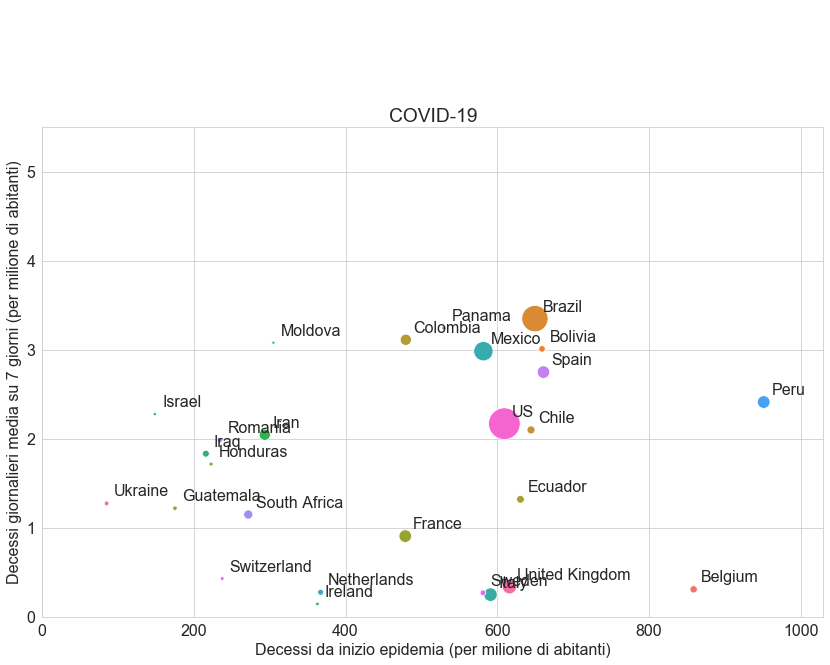

In [381]:
import seaborn as sns
# sns.set()
world_hit = world.sel(location=(((world['daily_mortality7'].isel(time=-1) > 1.) | (world['mortality'].isel(time=-1) > 200)) & (world['deaths'] > 1000)).any('time')).to_dataframe().reset_index()
#ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 5.5), xlim=(0, 1030))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_mortality7'] > 10:
        continue
    ax.annotate(record['location'], (record['mortality'] + 10, record['daily_mortality7'] + .08))
_ = ax.set(title='COVID-19', xlabel='Decessi da inizio epidemia (per milione di abitanti)', ylabel='Decessi giornalieri media su 7 giorni (per milione di abitanti)')

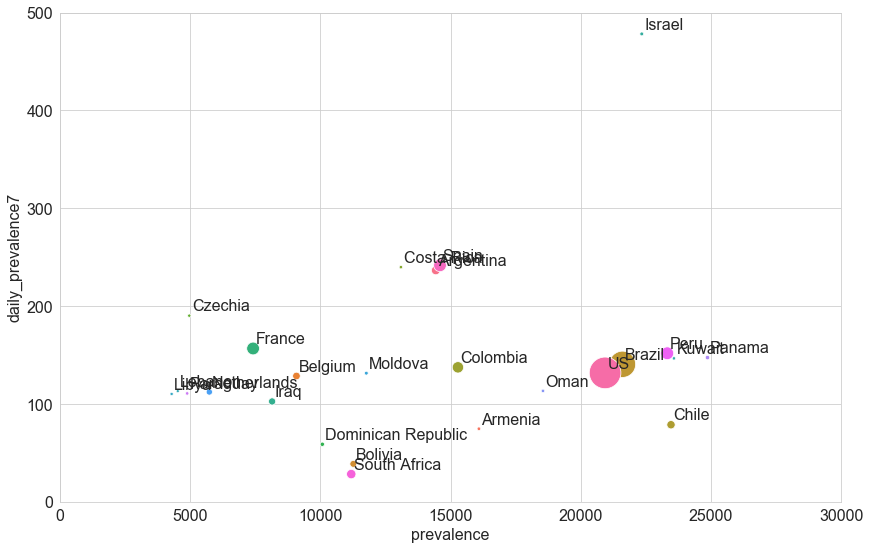

In [382]:
import seaborn as sns
# sns.set()
world_hit = world.sel(location=(((world['prevalence'].isel(time=-1) > 10000) | (world['daily_prevalence7'].isel(time=-1) > 100.)) & (world['deaths'] > 300.)).any('time')).to_dataframe().reset_index()
# ax = sns.scatterplot(y="daily_mortality7", x="daily_prevalence7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(y="daily_prevalence7", x="prevalence", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 500), xlim=(0, 30000))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_prevalence7'] > 500 or record['daily_mortality7'] > 30000:
        continue
    ax.annotate(record['location'], (record['prevalence'] + 100, record['daily_prevalence7'] + 5))

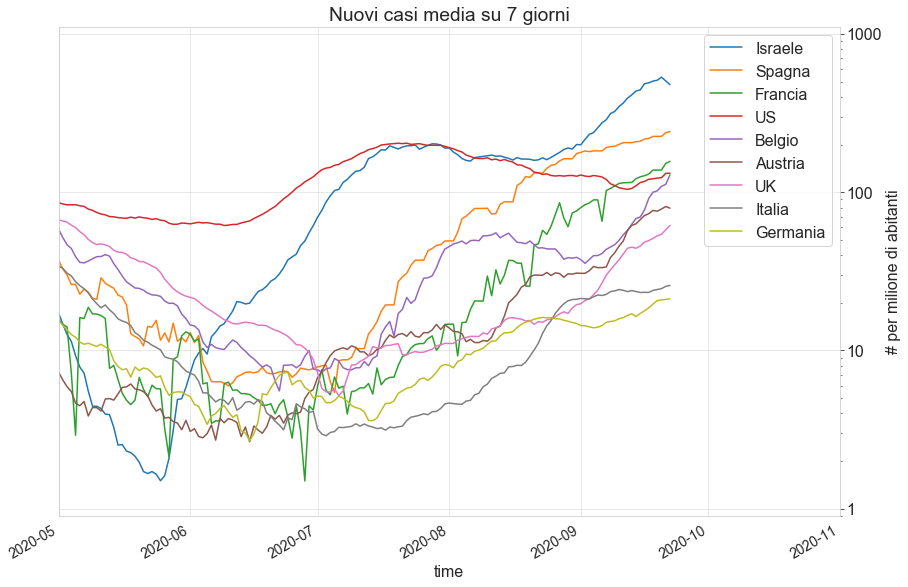

In [383]:
_, ax = covid19.plot.subplots()
#world.sel(location='Spain')['daily_confirmed7'].plot(label='Nuovi casi giornalieri (media su 7 giorni)')
#world.sel(location='Netherlands')['daily_prevalence7'].plot(label='Olanda')
#world.sel(location='Netherlands')['daily_mortality7'].plot(label='Olanda')
#world.sel(location='Croatia')['daily_prevalence7'].plot(label='Croatia')
#world.sel(location='Malta')['daily_prevalence7'].plot(label='Malta')
#world.sel(location='US')['daily_mortality7'].plot(label='US deaths')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud casi giornalieri (media su 7 giorni)')
#world.sel(location='Korea, South')['daily_mortality7'].plot(label='Corea del Sud')
(world.sel(location='Israel')['daily_prevalence7'] / 1).plot(label='Israele')
(world.sel(location='Spain')['daily_prevalence7'] / 1).plot(label='Spagna')
(world.sel(location='France')['daily_prevalence7'] / 1).plot(label='Francia')
(world.sel(location='US')['daily_prevalence7'] / 1).plot(label='US')
(world.sel(location='Belgium')['daily_prevalence7'] / 1).plot(label='Belgio')
(world.sel(location='Austria')['daily_prevalence7'] / 1).plot(label='Austria')
(world.sel(location='United Kingdom')['daily_prevalence7'] / 1).plot(label='UK')
(world.sel(location='Italy')['daily_prevalence7'] / 1).plot(label='Italia')
(world.sel(location='Germany')['daily_prevalence7'] / 1).plot(label='Germania')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
#world.sel(location='United Kingdom')['daily_mortality7'].plot(label='UK - decessi')
#world.sel(location='France')['daily_mortality7'].plot(label='Francia - decessi')
#world.sel(location='Austria')['daily_mortality7'].plot(label='Austria decessi giornalieri (media suà 7 giorni)')
#world.sel(location='Israel')['daily_mortality7'].plot(label='Israele - decessi')
#world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna - decessi')
#world.sel(location='Germany')['daily_mortality7'].plot(label='Germania - decessi')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Sweden')['daily_mortality7'].plot(label='Svezia - decessi')
plt.legend(loc='upper right')
plt.ylim(0.9, 1000 / 0.9)
plt.xlim(np.datetime64('2020-05-01'), np.datetime64('2020-11-01'))
plt.yscale('log')
plt.ylabel('# per milione di abitanti')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = plt.title("Nuovi casi media su 7 giorni")

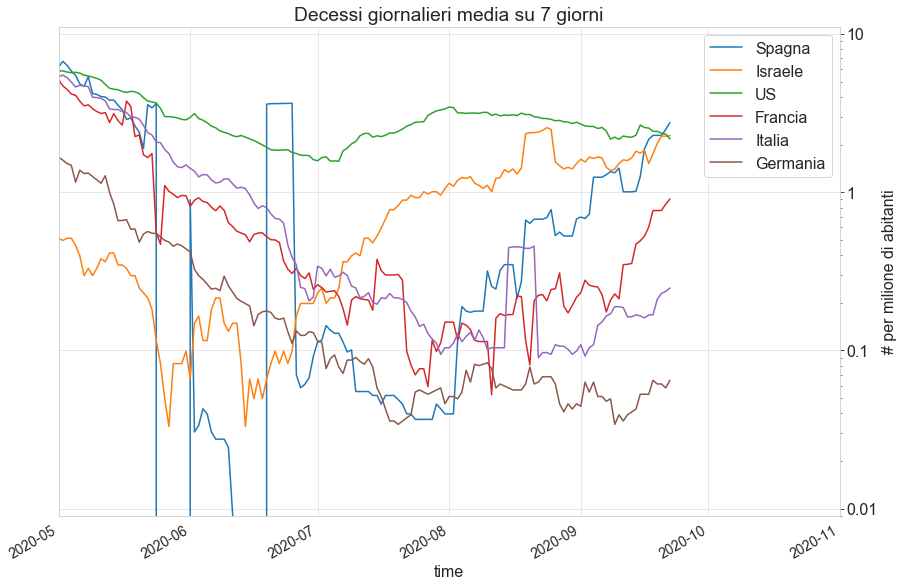

In [367]:
_, ax = covid19.plot.subplots()
#world.sel(location='Spain')['daily_confirmed7'].plot(label='Nuovi casi giornalieri (media su 7 giorni)')
#world.sel(location='Netherlands')['daily_prevalence7'].plot(label='Olanda')
#world.sel(location='Netherlands')['daily_mortality7'].plot(label='Olanda')
#world.sel(location='Croatia')['daily_prevalence7'].plot(label='Croatia')
#world.sel(location='Malta')['daily_prevalence7'].plot(label='Malta')
#world.sel(location='US')['daily_mortality7'].plot(label='US deaths')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud casi giornalieri (media su 7 giorni)')
#world.sel(location='Korea, South')['daily_mortality7'].plot(label='Corea del Sud')
(world.sel(location='Spain')['daily_mortality7'] / 1).plot(label='Spagna')
(world.sel(location='Israel')['daily_mortality7'] / 1).plot(label='Israele')
(world.sel(location='US')['daily_mortality7'] / 1).plot(label='US')
(world.sel(location='France')['daily_mortality7'] / 1).plot(label='Francia')
#(world.sel(location='United Kingdom')['daily_mortality7'] / 1).plot(label='UK')
#(world.sel(location='Belgium')['daily_mortality7'] / 1).plot(label='Belgio')
#(world.sel(location='Austria')['daily_mortality7'] / 1).plot(label='Austria')
(world.sel(location='Italy')['daily_mortality7'] / 1).plot(label='Italia')
(world.sel(location='Germany')['daily_mortality7'] / 1).plot(label='Germania')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
#world.sel(location='United Kingdom')['daily_mortality7'].plot(label='UK - decessi')
#world.sel(location='France')['daily_mortality7'].plot(label='Francia - decessi')
#world.sel(location='Austria')['daily_mortality7'].plot(label='Austria decessi giornalieri (media suà 7 giorni)')
#world.sel(location='Israel')['daily_mortality7'].plot(label='Israele - decessi')
#world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna - decessi')
#world.sel(location='Germany')['daily_mortality7'].plot(label='Germania - decessi')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Sweden')['daily_mortality7'].plot(label='Svezia - decessi')
plt.legend(loc='upper right')
plt.ylim(0.009, 10 / 0.9)
plt.xlim(np.datetime64('2020-05-01'), np.datetime64('2020-11-01'))
plt.yscale('log')
plt.ylabel('# per milione di abitanti')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = plt.title("Decessi giornalieri media su 7 giorni")

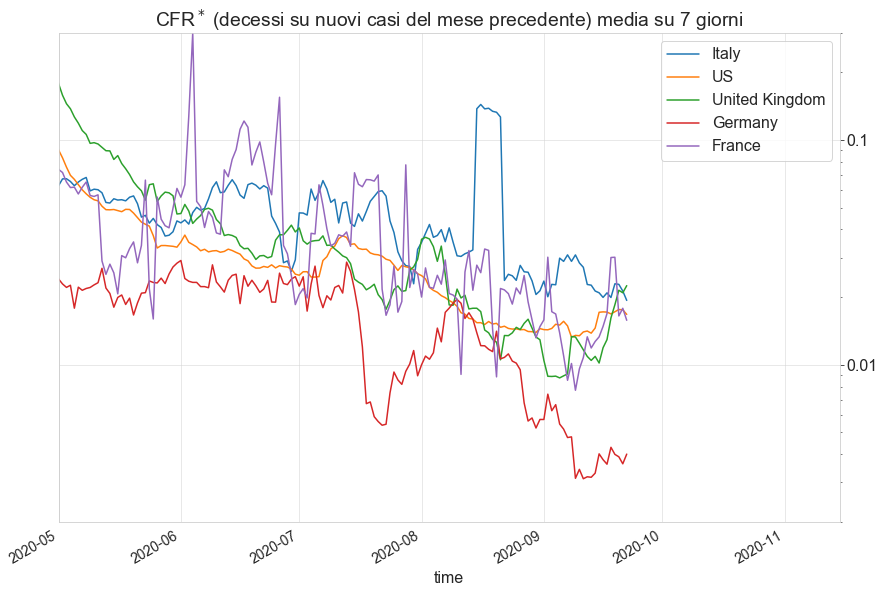

In [389]:
_, ax = covid19.plot.subplots()
#world.sel(location='Spain')['daily_confirmed7'].plot(label='Nuovi casi giornalieri (media su 7 giorni)')
#world.sel(location='Netherlands')['daily_prevalence7'].plot(label='Olanda')
#world.sel(location='Netherlands')['daily_mortality7'].plot(label='Olanda')
#world.sel(location='Croatia')['daily_prevalence7'].plot(label='Croatia')
#world.sel(location='Malta')['daily_prevalence7'].plot(label='Malta')
#world.sel(location='US')['daily_mortality7'].plot(label='US deaths')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud casi giornalieri (media su 7 giorni)')
#world.sel(location='Korea, South')['daily_mortality7'].plot(label='Corea del Sud')
#(world.sel(location='Spain')['daily_mortality7'] / 1).plot(label='Spagna')
#(world.sel(location='Israel')['daily_mortality7'] / 1).plot(label='Israele')
#(world.sel(location='US')['daily_mortality7'] / 1).plot(label='US')
#(world.sel(location='France')['daily_mortality7'] / 1).plot(label='Francia')
#(world.sel(location='United Kingdom')['daily_mortality7'] / 1).plot(label='UK')
#(world.sel(location='Belgium')['daily_mortality7'] / 1).plot(label='Belgio')
#(world.sel(location='Austria')['daily_mortality7'] / 1).plot(label='Austria')
delay = 30
for country in ['Italy', 'US', 'United Kingdom', 'Germany', 'France']:
    data = world.sel(location=country)
    #data['daily_mortality7'].plot(label=f'{country} - mortalità')
    #data['daily_prevalence7'].plot(label=f'{country}')
    #data['daily_prevalence7'].shift({'time': delay}).plot(label=f'{country}')
    (data['daily_mortality7'] / data['daily_prevalence7'].shift({'time': delay})).plot(label=f'{country}')
    
#world.sel(location='Italy')['daily_prevalence7'].plot(label='Italia - casi')
#world.sel(location='Germany')['daily_prevalence7'].plot(label='Germania - casi')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Germany')['daily_mortality7'].plot(label='Germania- decessi')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
#world.sel(location='United Kingdom')['daily_mortality7'].plot(label='UK - decessi')
#world.sel(location='France')['daily_mortality7'].plot(label='Francia - decessi')
#world.sel(location='Austria')['daily_mortality7'].plot(label='Austria decessi giornalieri (media suà 7 giorni)')
#world.sel(location='Israel')['daily_mortality7'].plot(label='Israele - decessi')
#world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna - decessi')
#world.sel(location='Germany')['daily_mortality7'].plot(label='Germania - decessi')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Sweden')['daily_mortality7'].plot(label='Svezia - decessi')
plt.legend(loc='upper right')
plt.ylim(0.002, 0.3)
plt.xlim(np.datetime64('2020-05-01'), np.datetime64('2020-11-15'))
plt.yscale('log')
#plt.ylabel('# per milione di abitanti')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = plt.title("CFR$^*$ (decessi su nuovi casi del mese precedente) media su 7 giorni")

In [311]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

SHOWUNTIL = np.datetime64(world.time.values[-1], 's') + 10 * DAY

EXTENT = ('2020-02-20', SHOWUNTIL)
XLIM = tuple(map(np.datetime64, EXTENT))
XLIM_S = tuple([np.datetime64(d) + 10 * DAY for d in EXTENT])

In [312]:
PARAMS = {
    'China / Hubei': -36,
    'Iran': -2,
    'Korea, South': -1,
    'Italy': 0,
#     'EU': 0,
    'Spain': 5,
    'France': 11,
    'US': 12,
    'Japan': 13,
    'United Kingdom': 14,
    'Netherlands': 16,
    'Germany': 18,
    'Switzerland': 18,
    'Philippines': 18,
    'Indonesia': 19,
    'Belgium': 20,
    'Turkey': 21,
    'Brazil': 21,
    'Sweden': 23,
    'Algeria': 23,
    'Austria': 24,
    'Portugal': 24,
    'Ecuador': 24,
    'India': 29,
    'Canada / Ontario': 29,
    'Canada / Quebec': 30,
    'Mexico': 31,
    'Russia': 33,
}

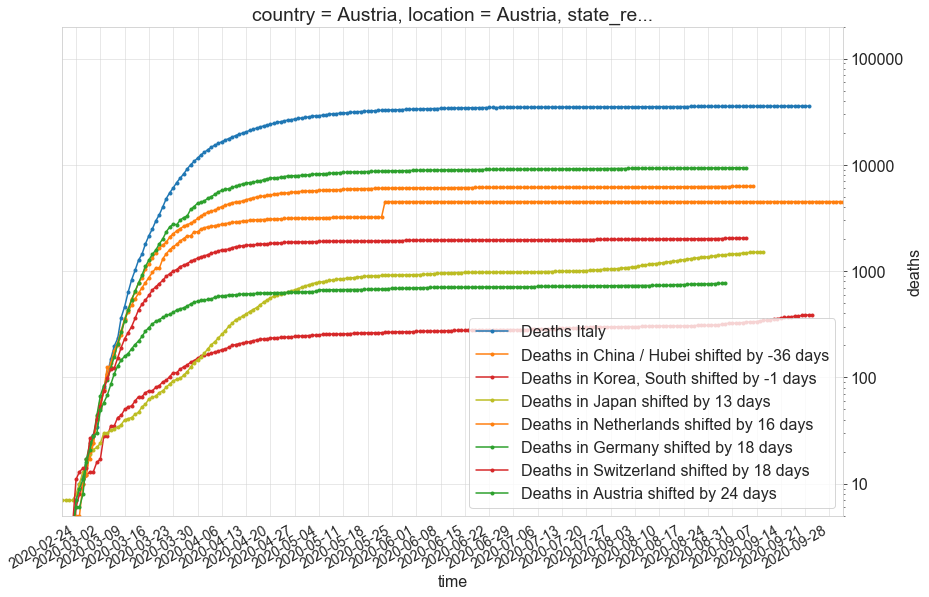

In [313]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 200000), 'xlim': XLIM}, figsize=(14, 9))
covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[1:])):
    if country not in ['Germany', 'Switzerland', 'Austria', 'Netherlands', 'Korea, South', 'Japan', 'China / Hubei']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color)
_ = ax.legend()

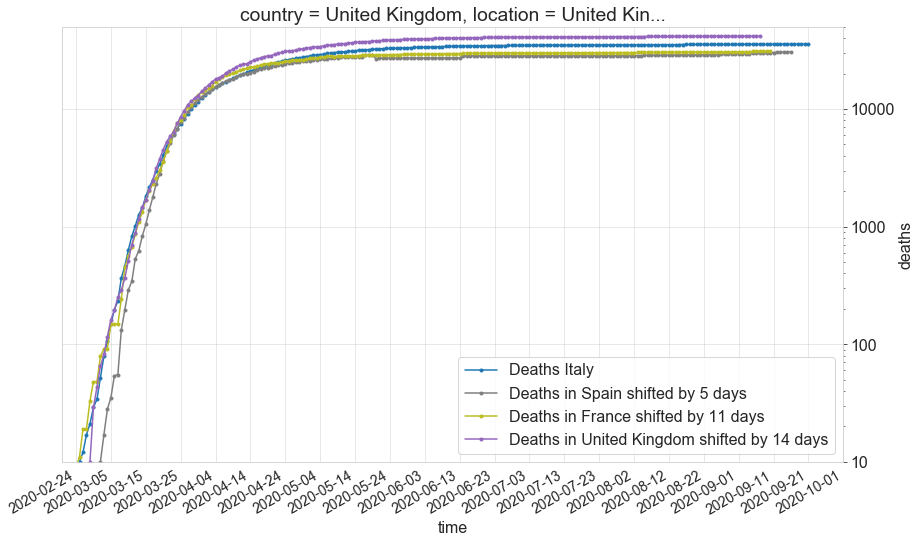

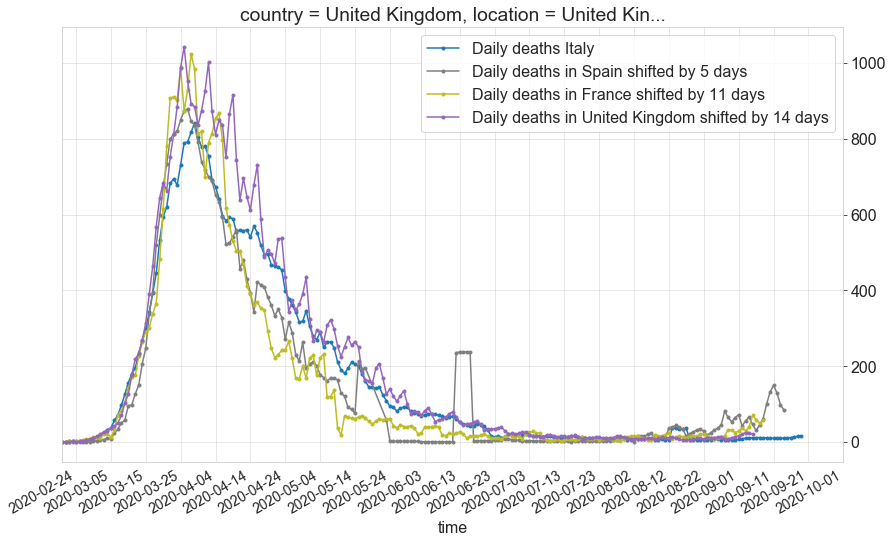

In [279]:
_, ax = covid19.plot.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 50000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = covid19.plot.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['France', 'United Kingdom', 'Spain']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

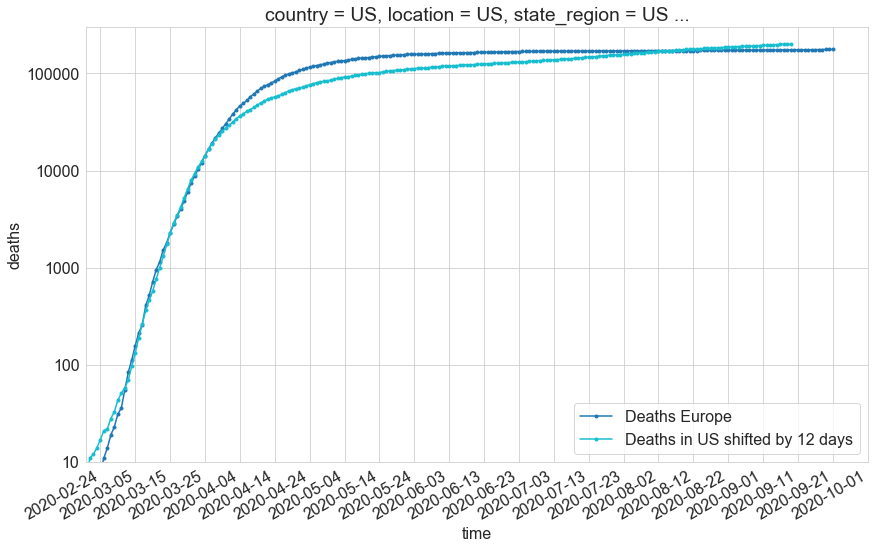

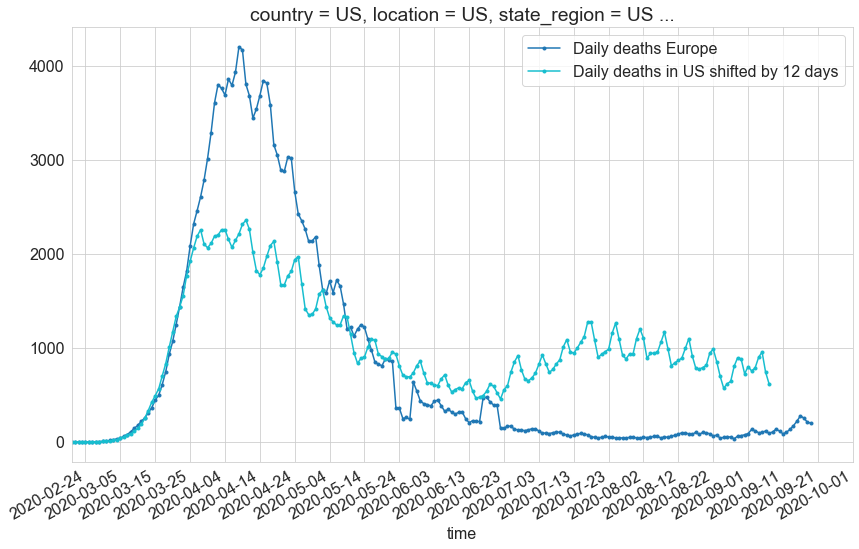

In [280]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 300000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = plt.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, europe['deaths'], label=f'Deaths Europe', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, europe['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Europe', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['US']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

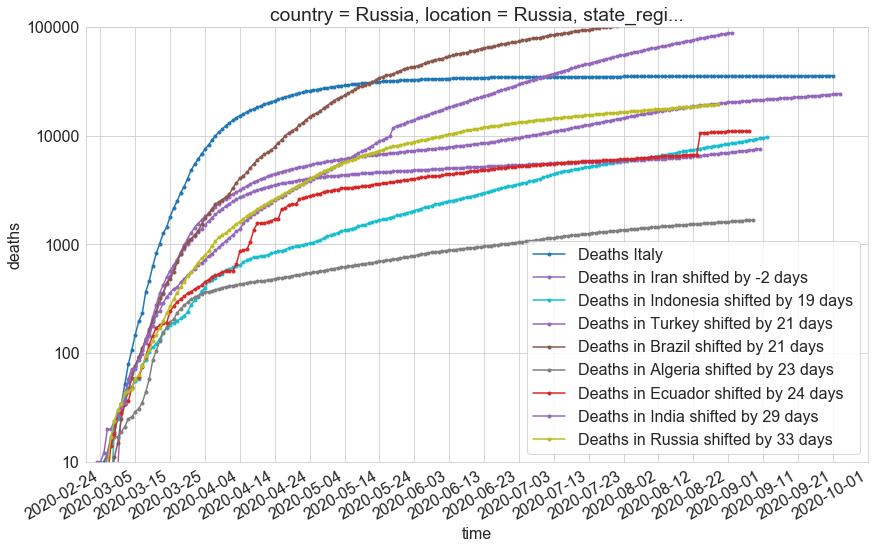

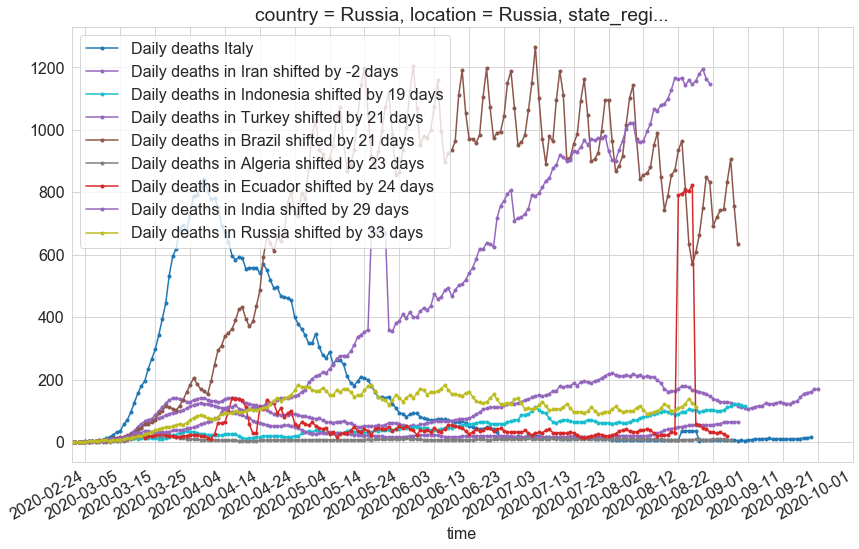

In [281]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 100000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = plt.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['Iran', 'Brazil', 'Turkey', 'India', 'Indonesia', 'Ecuador', 'Algeria', 'Russia']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

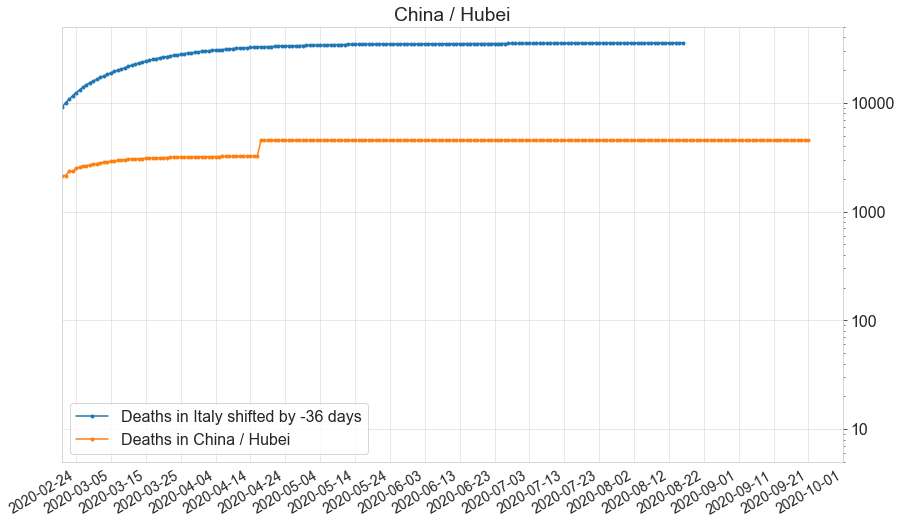

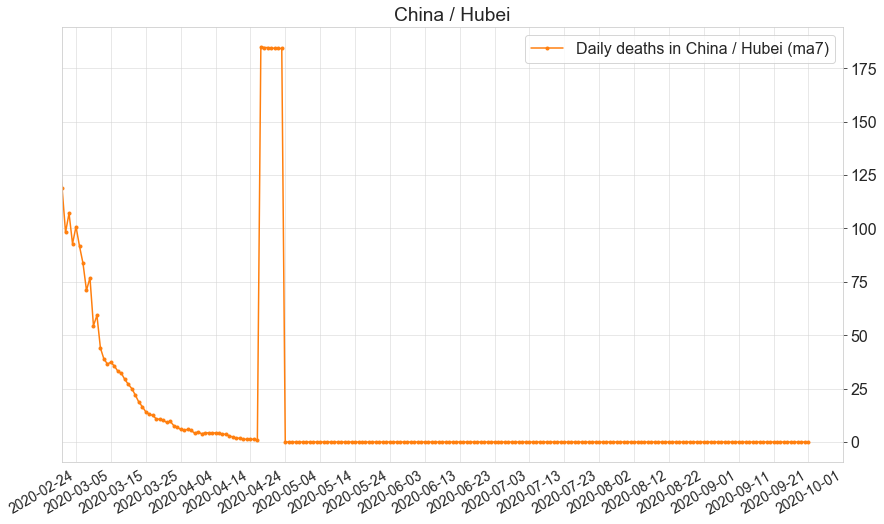

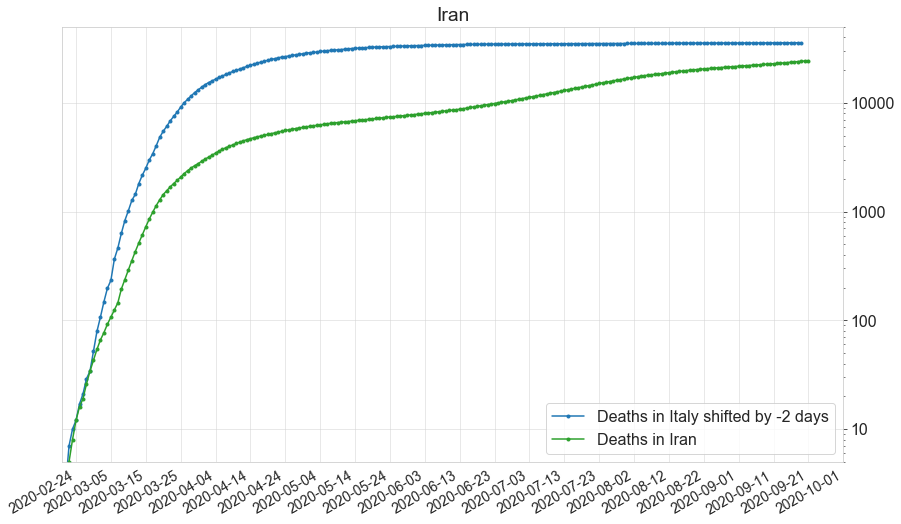

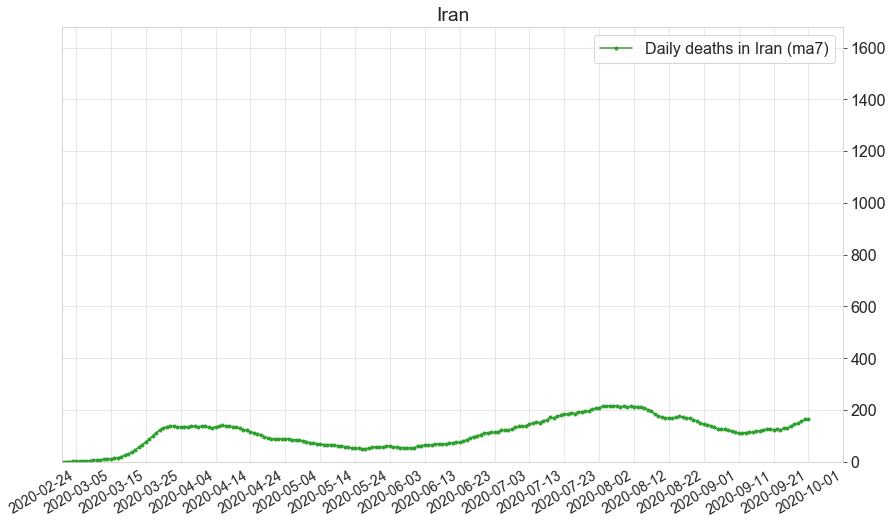

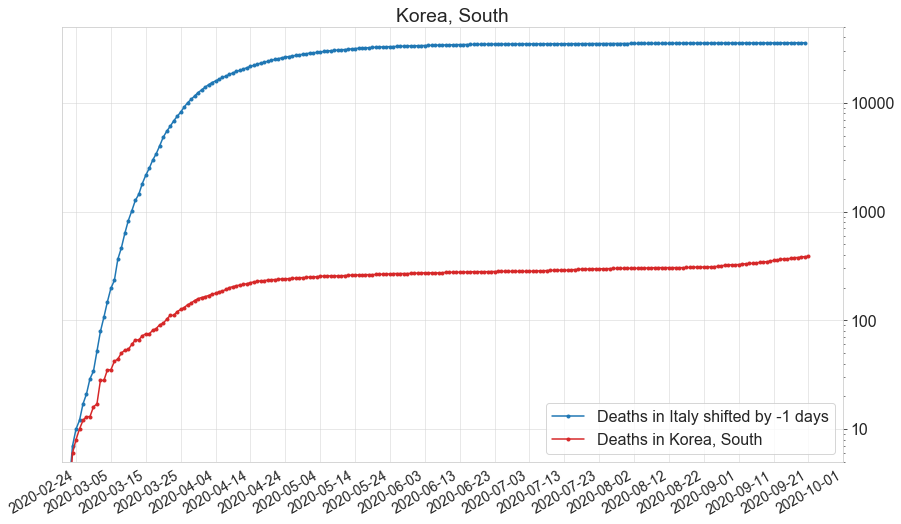

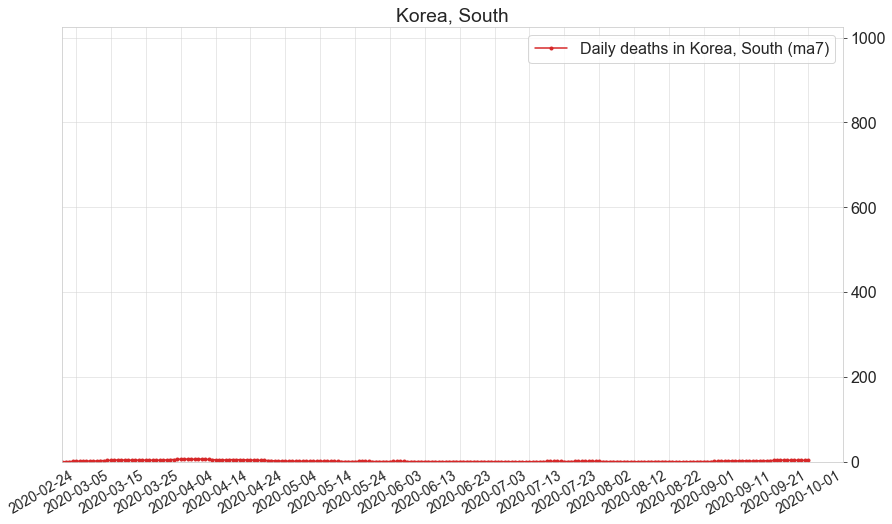

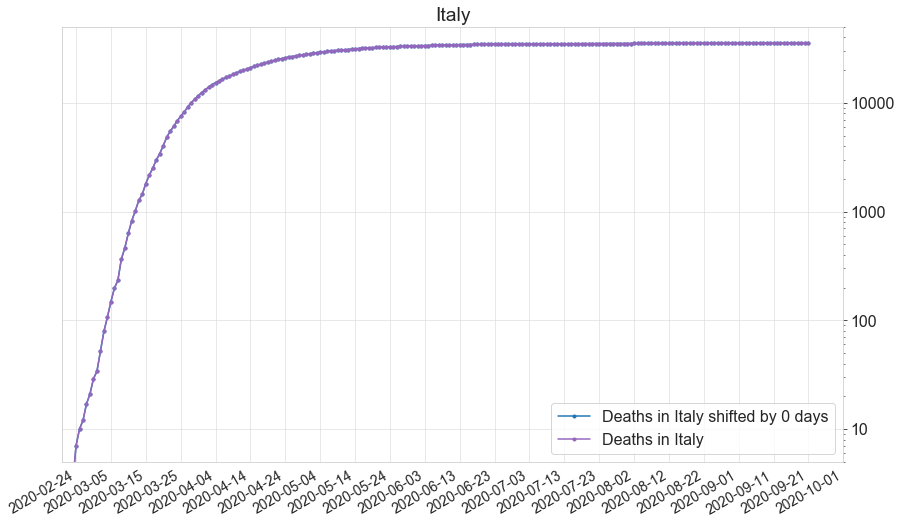

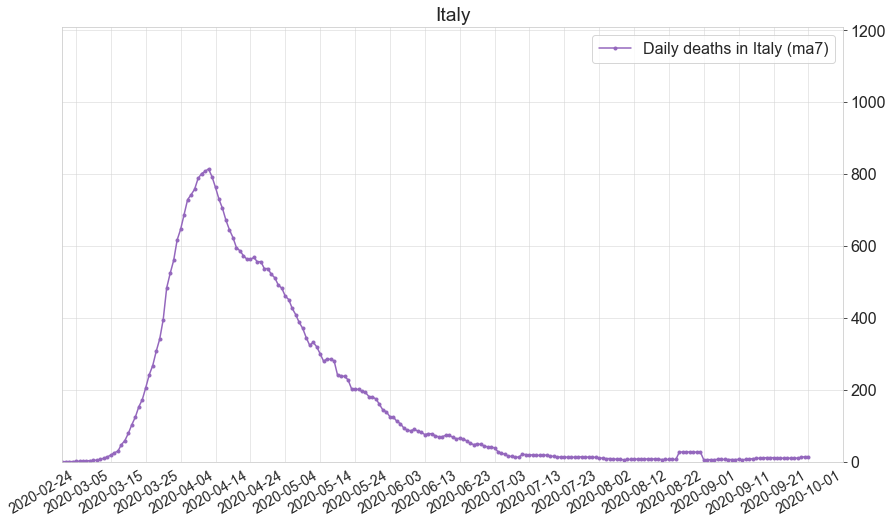

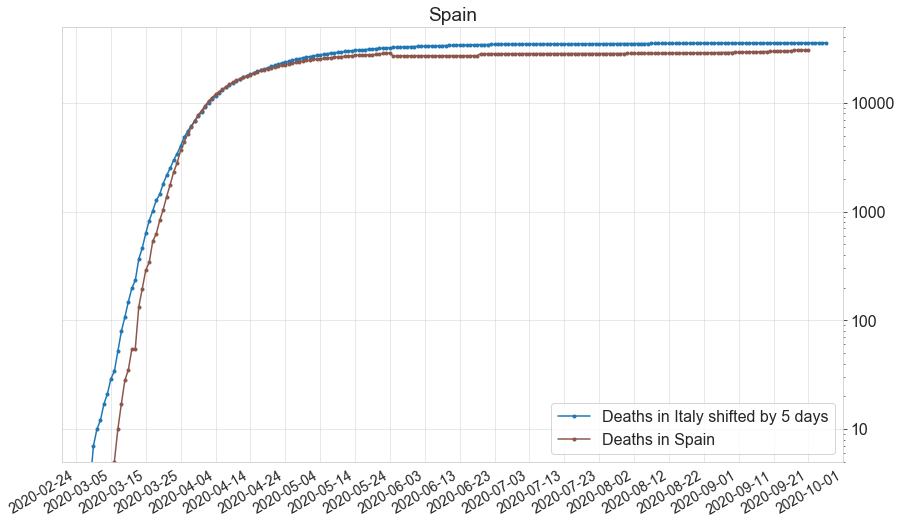

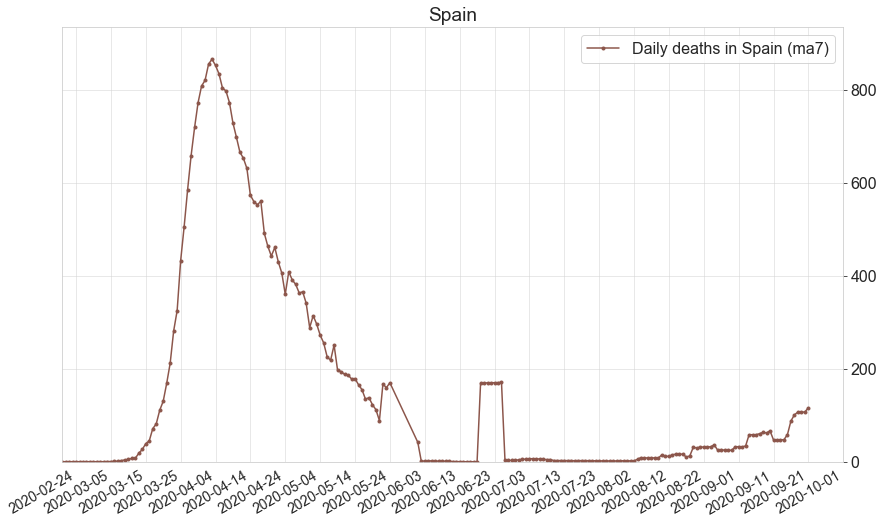

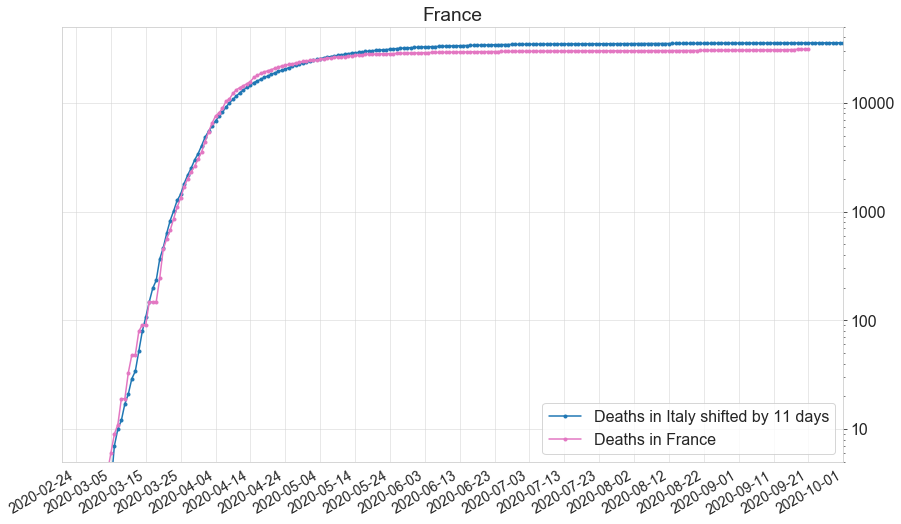

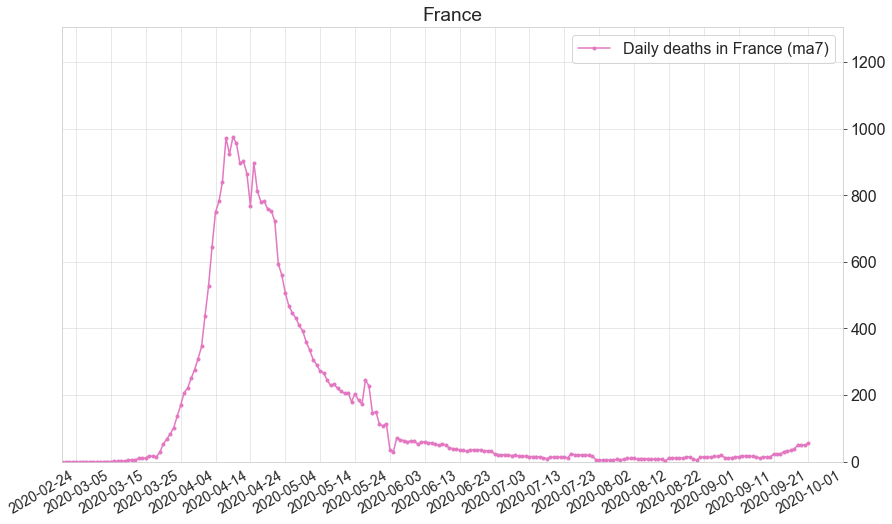

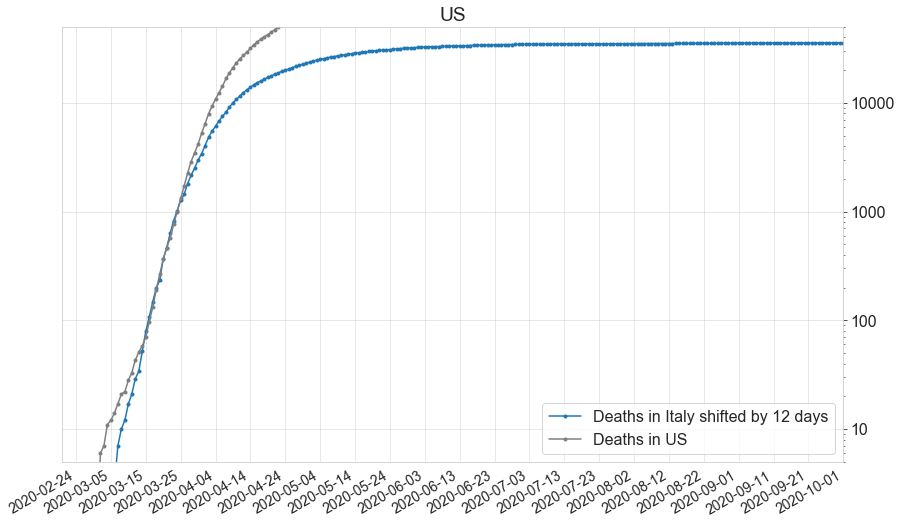

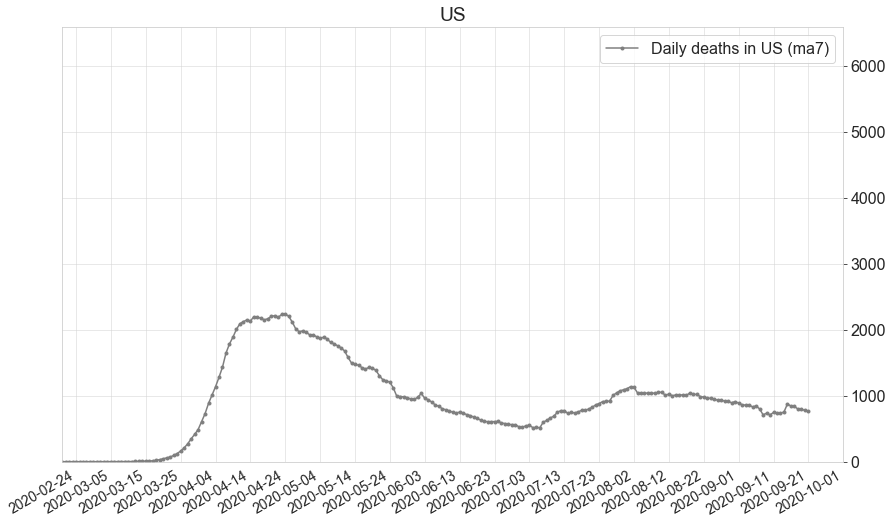

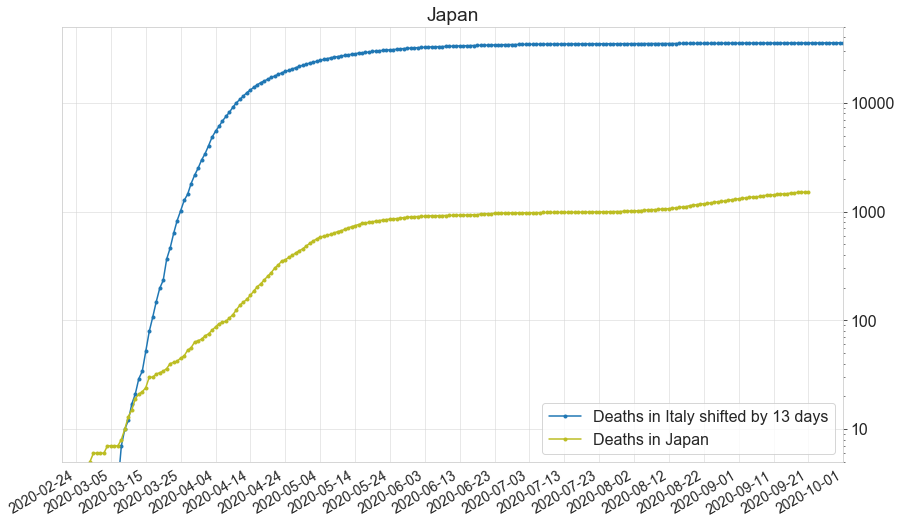

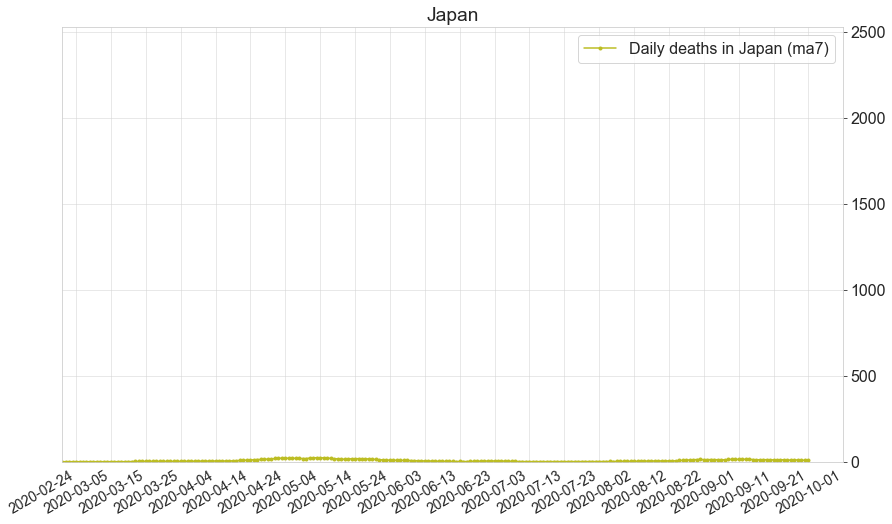

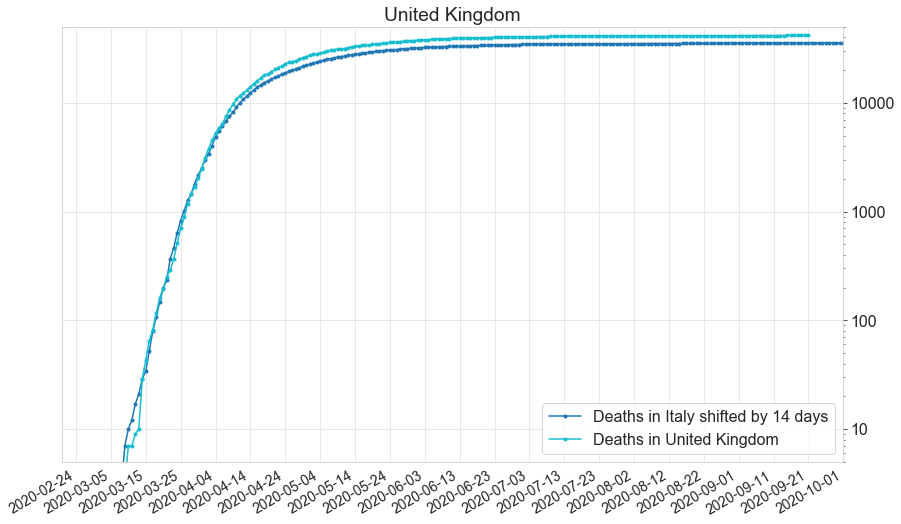

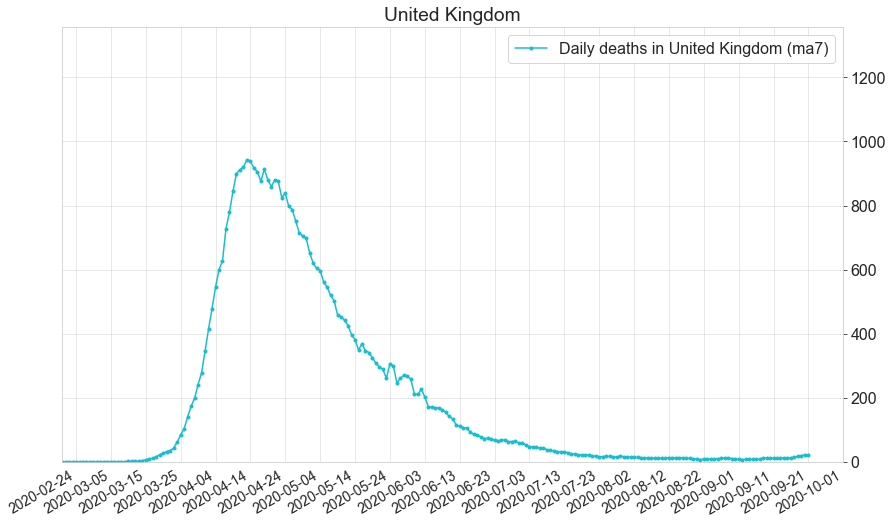

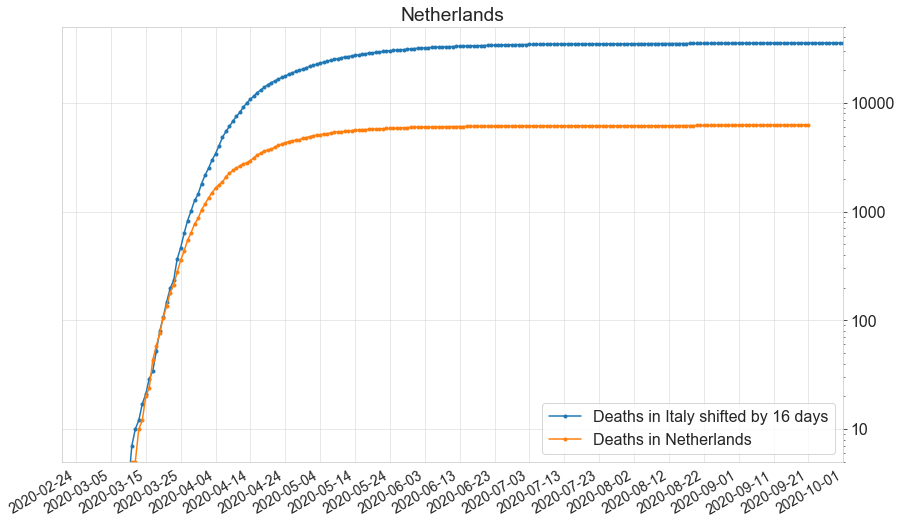

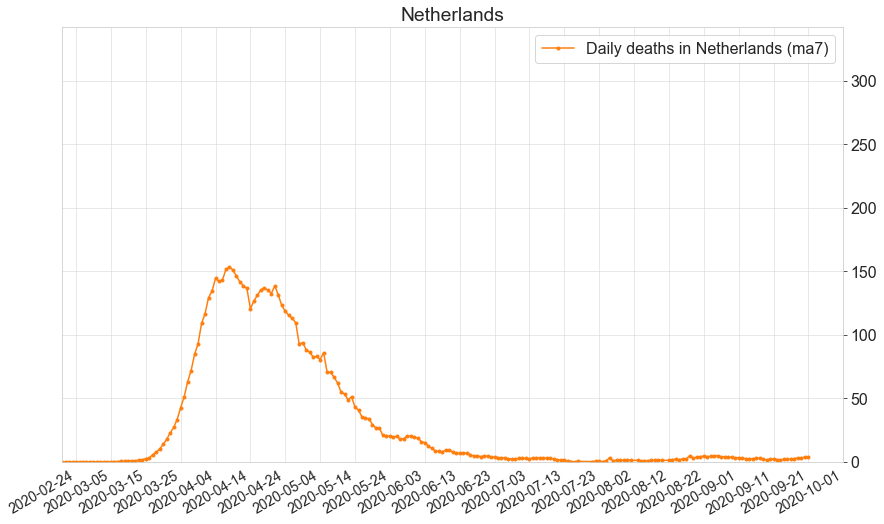

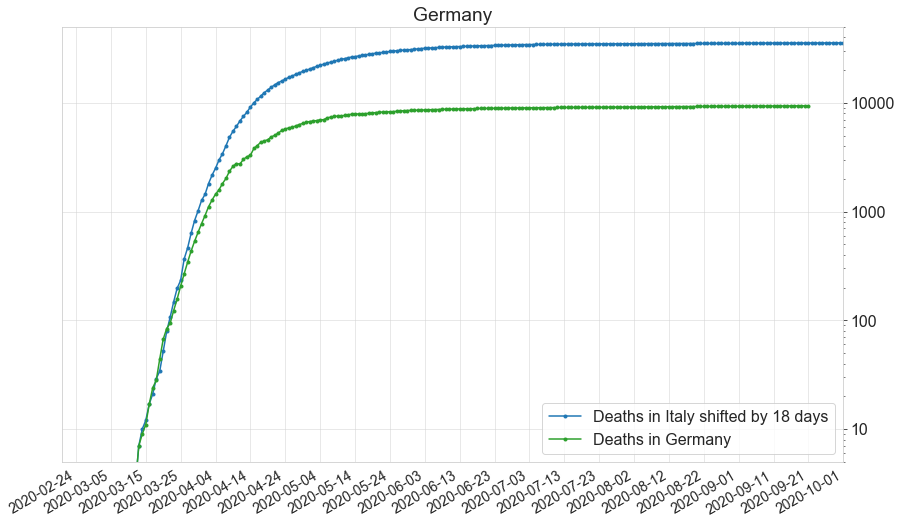

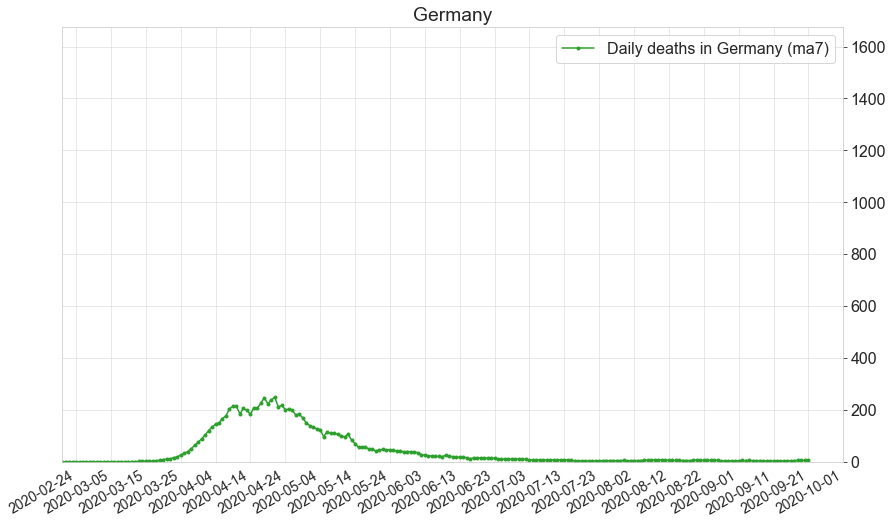

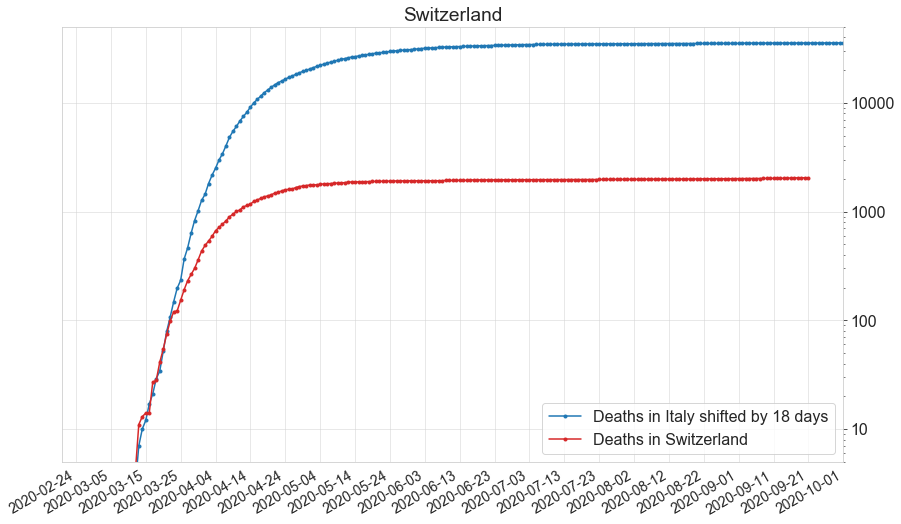

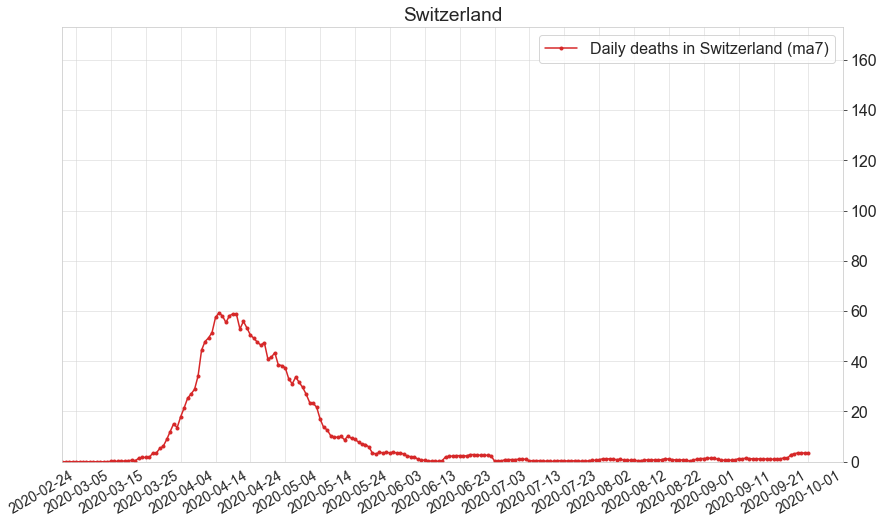

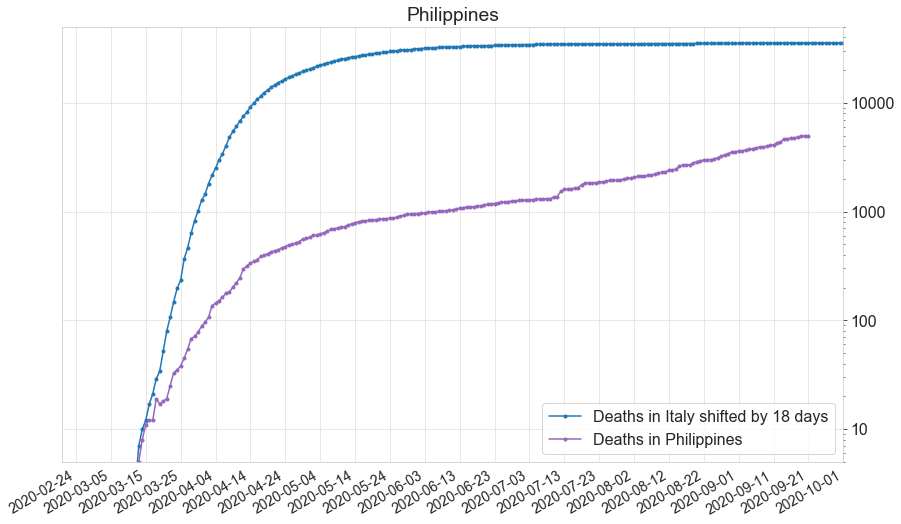

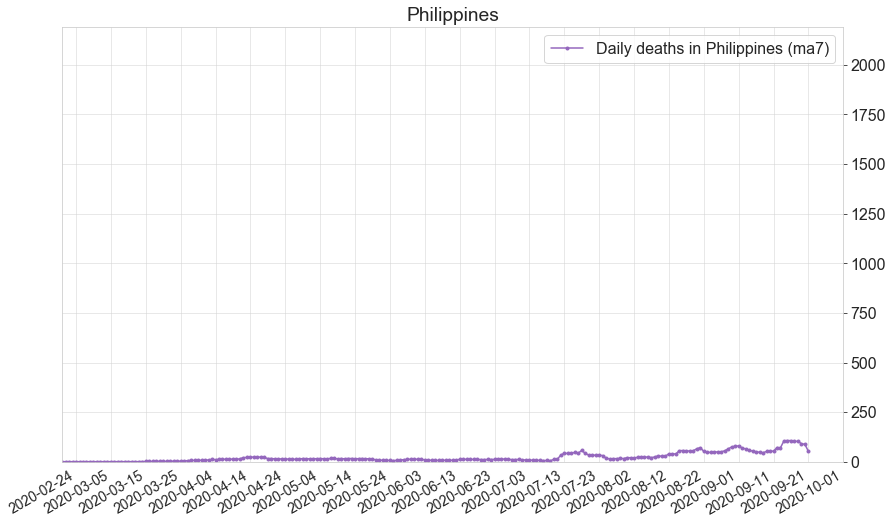

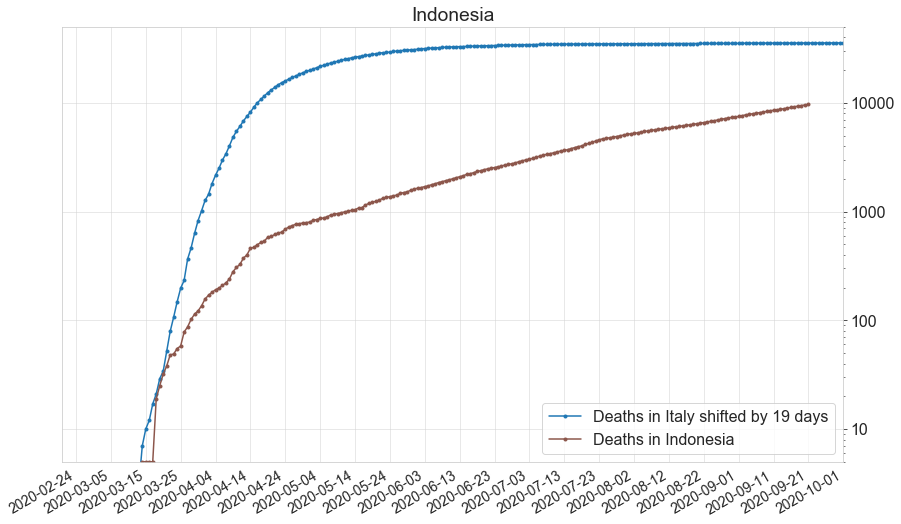

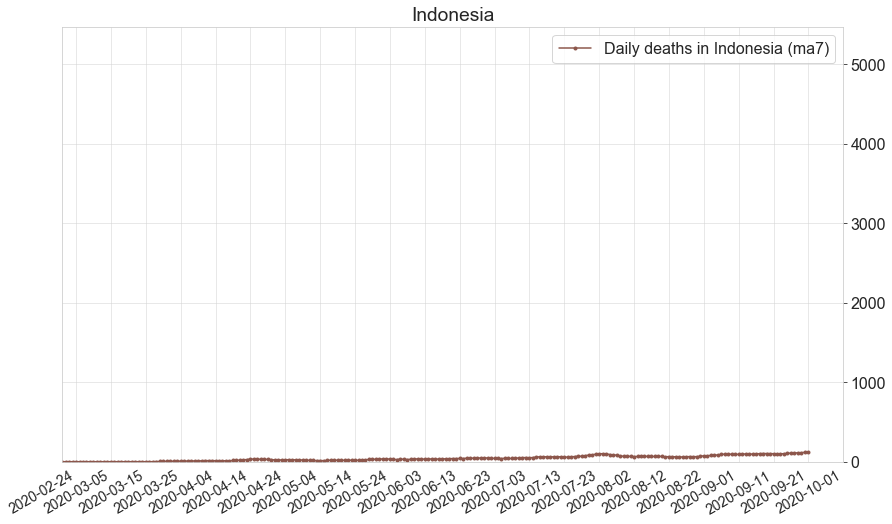

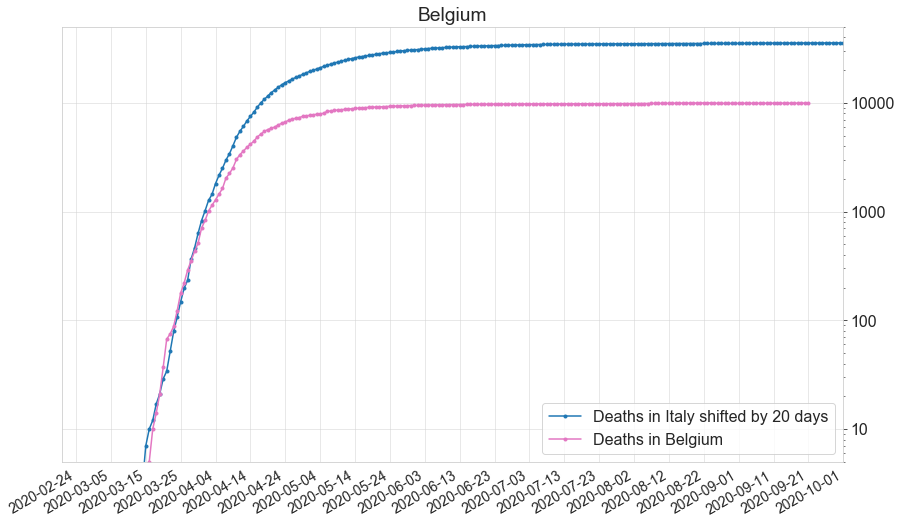

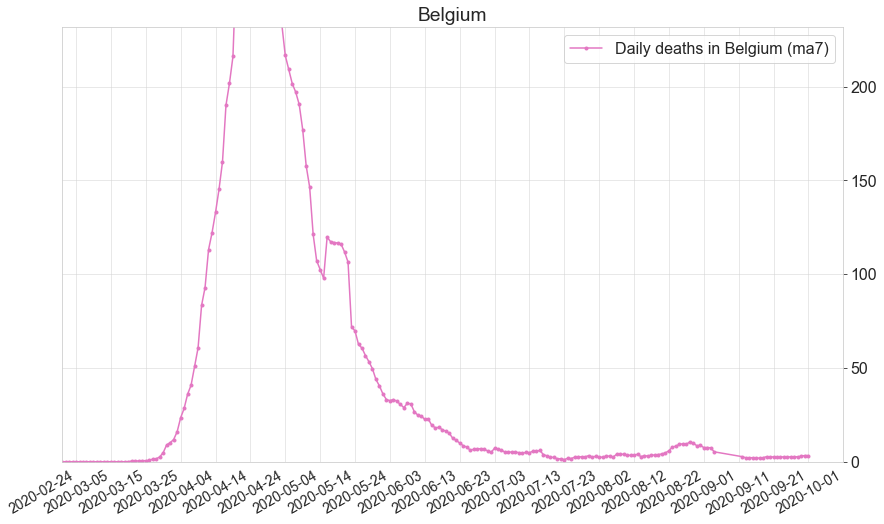

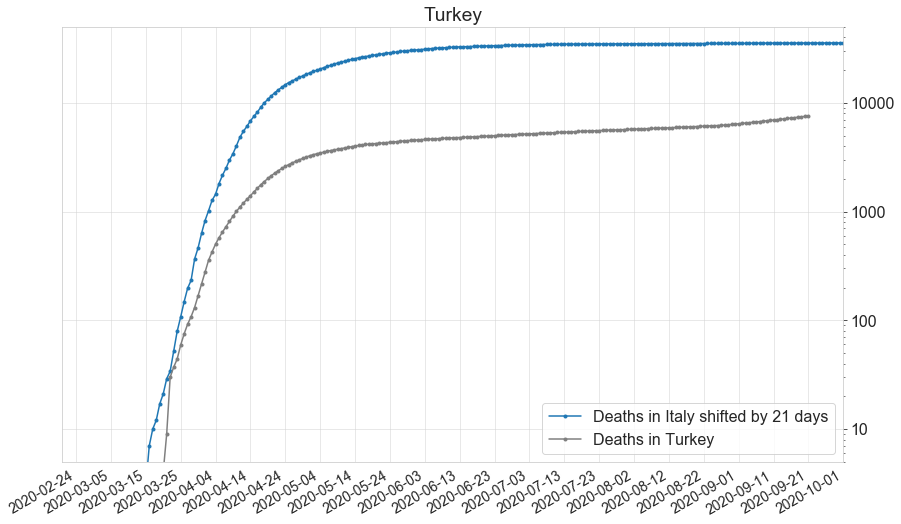

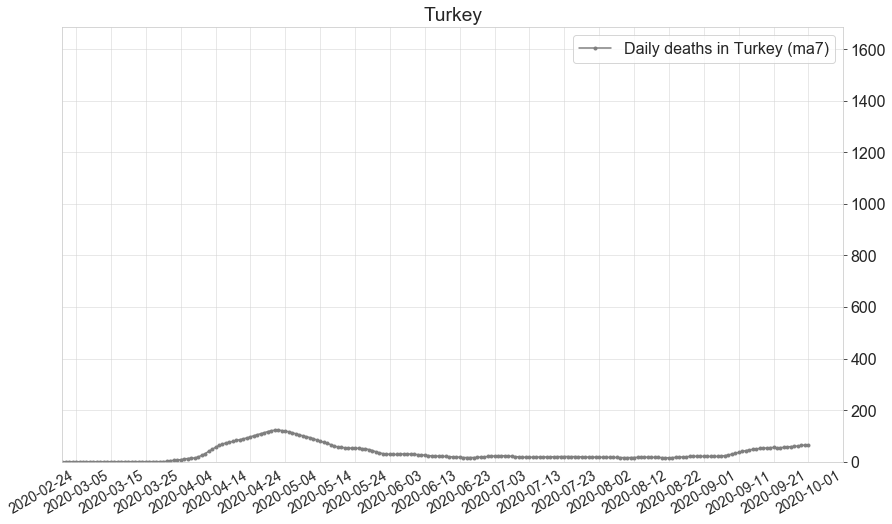

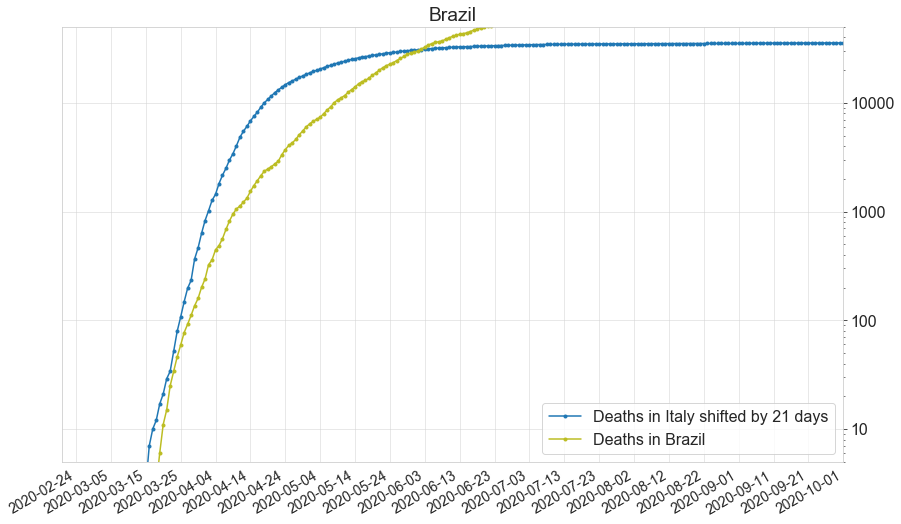

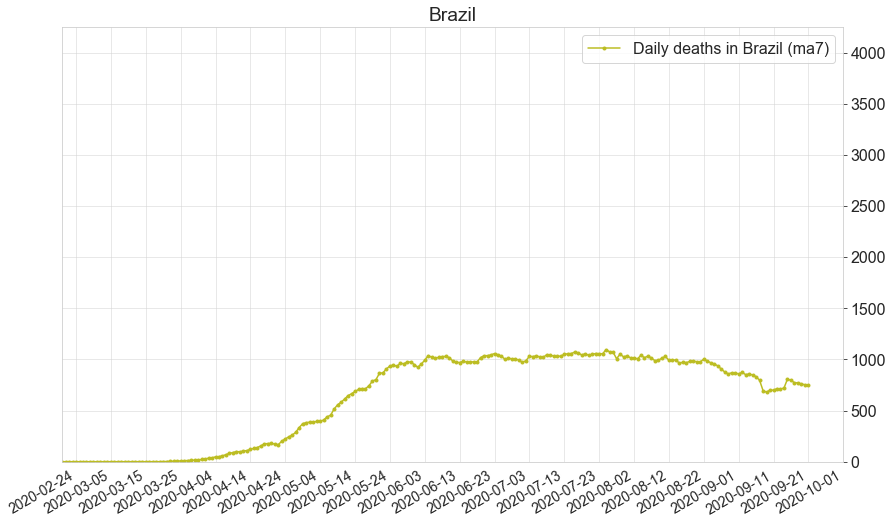

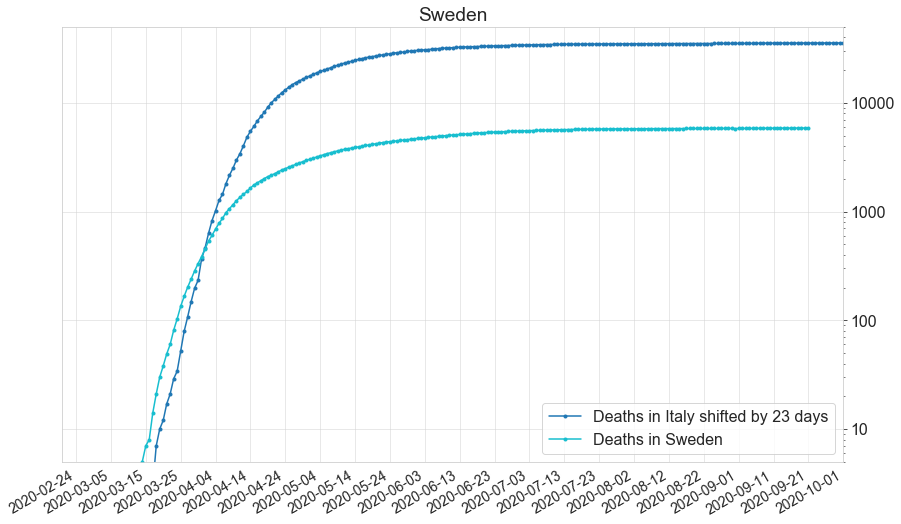

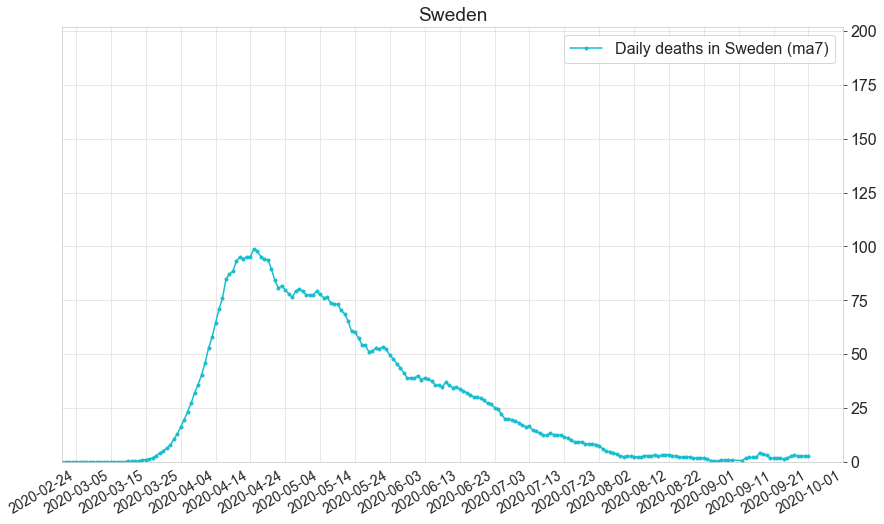

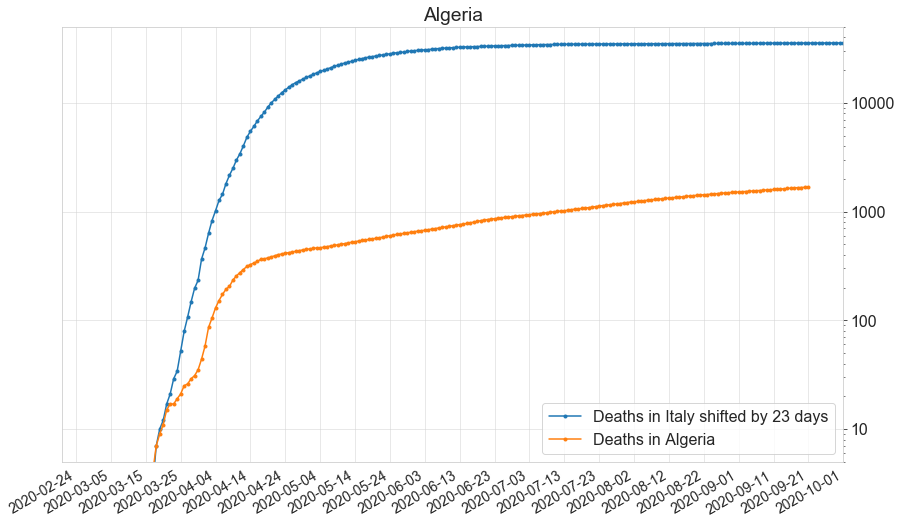

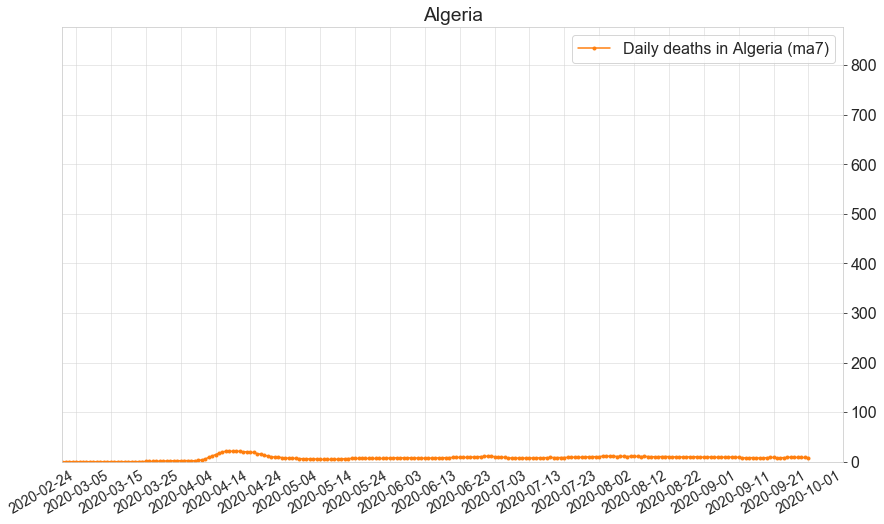

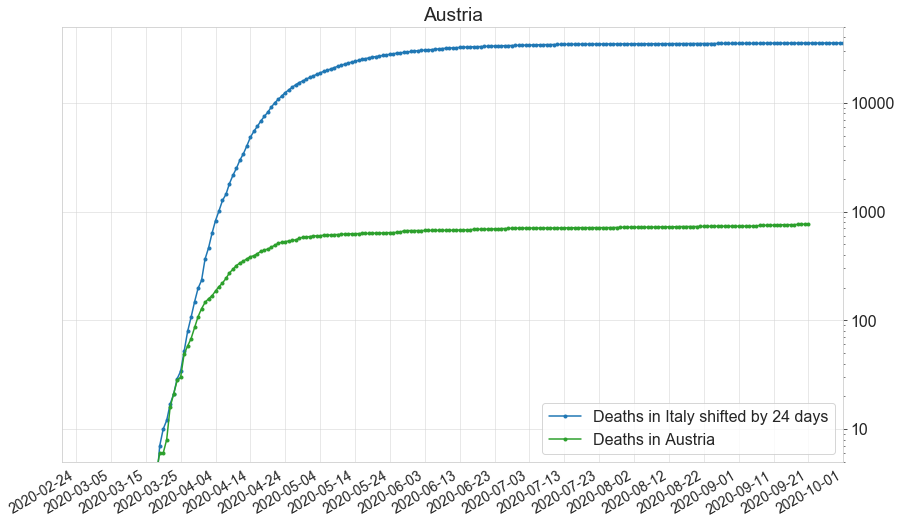

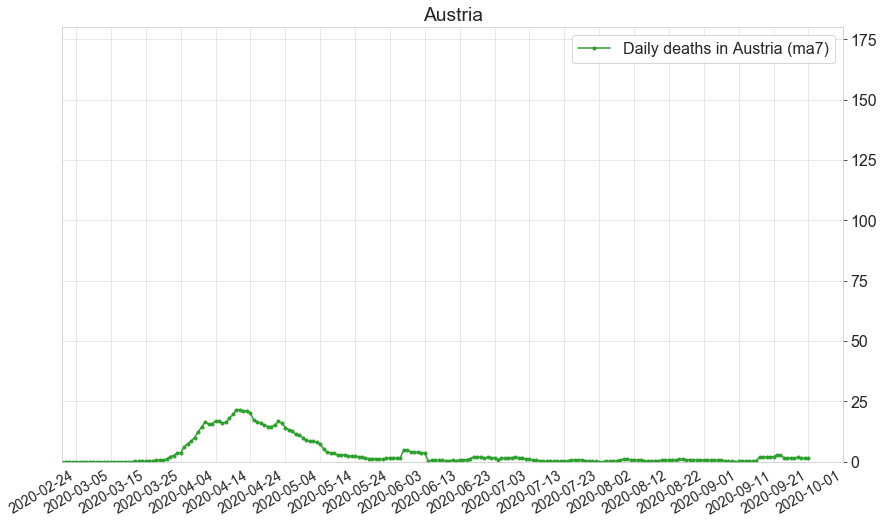

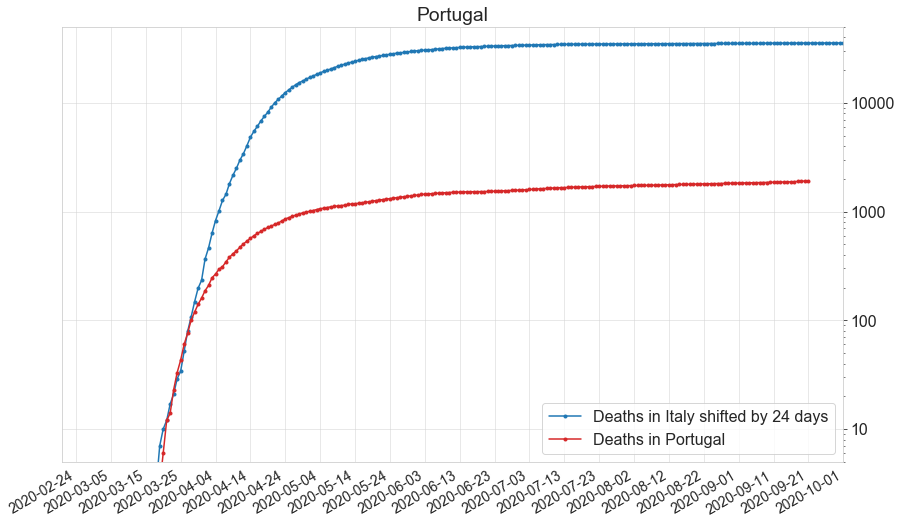

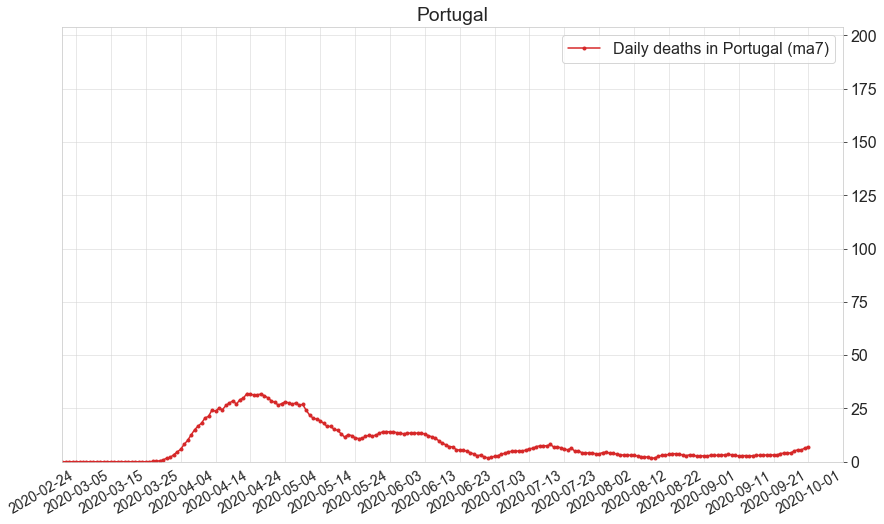

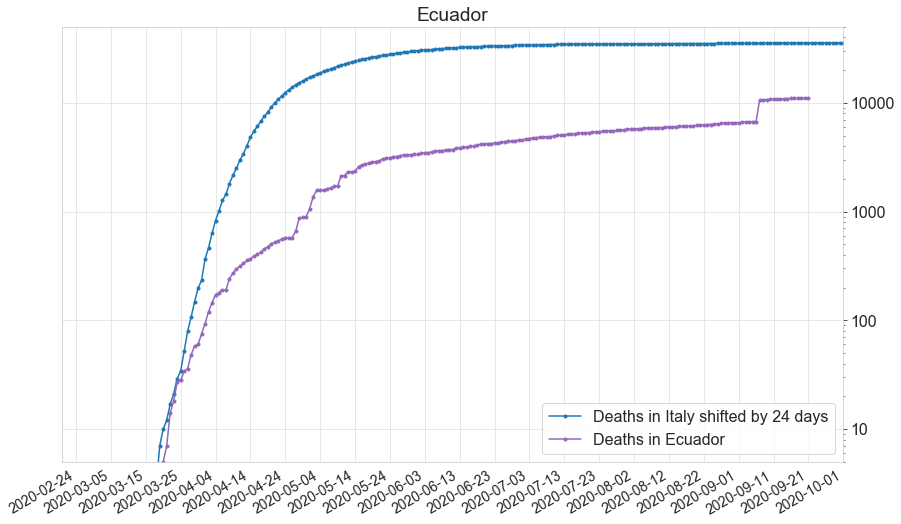

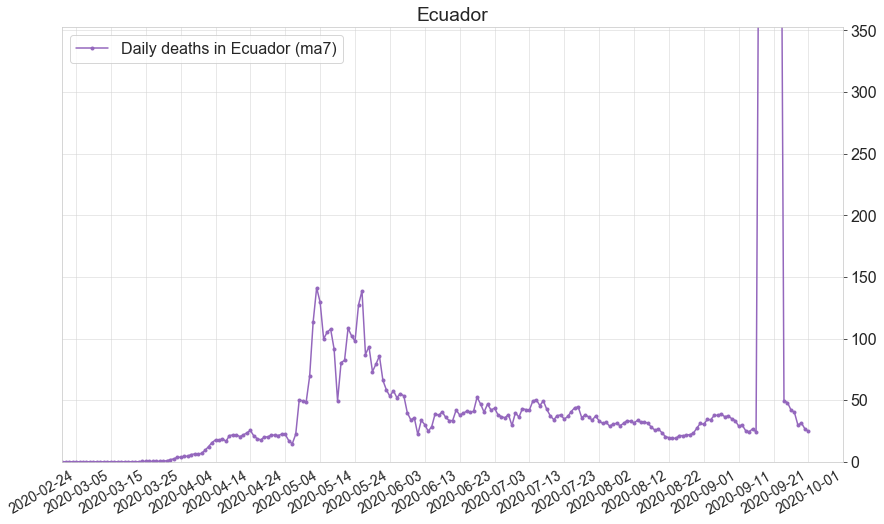

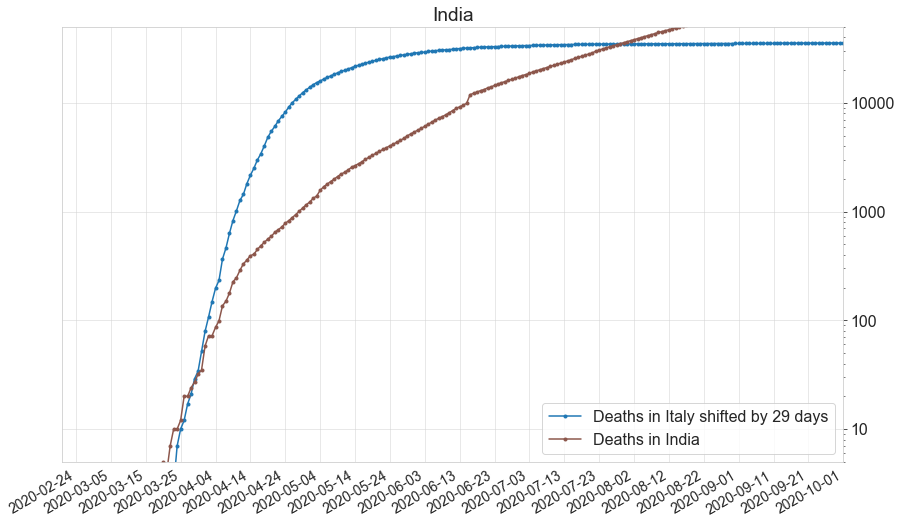

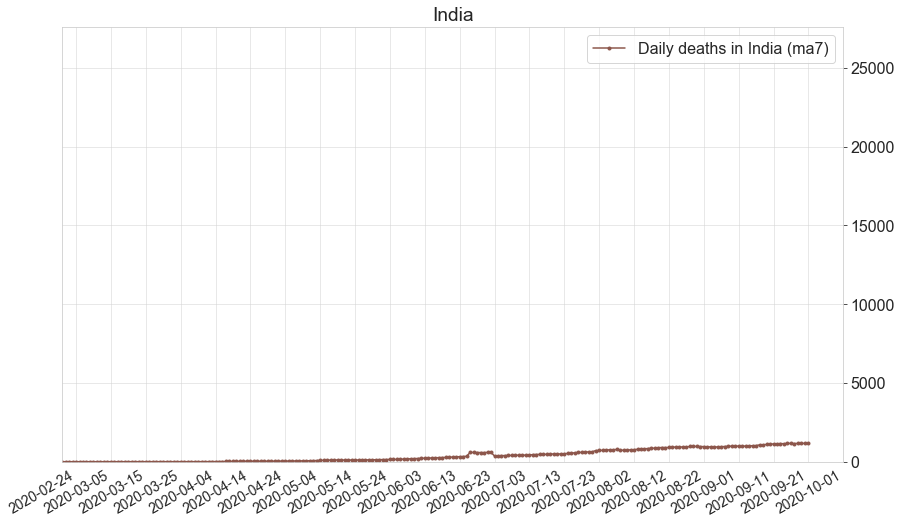

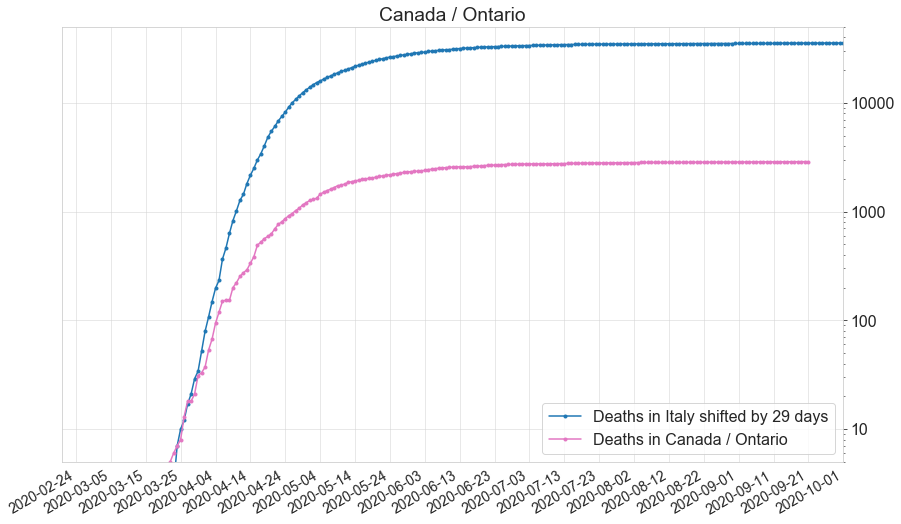

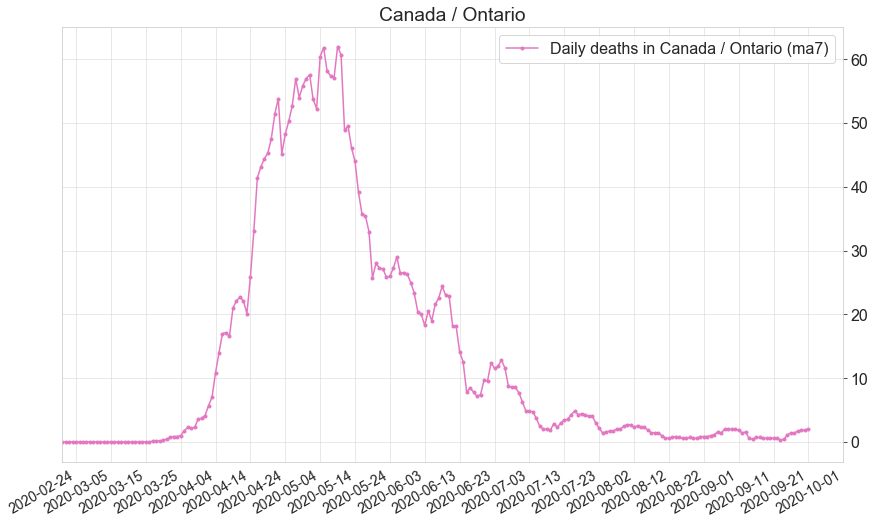

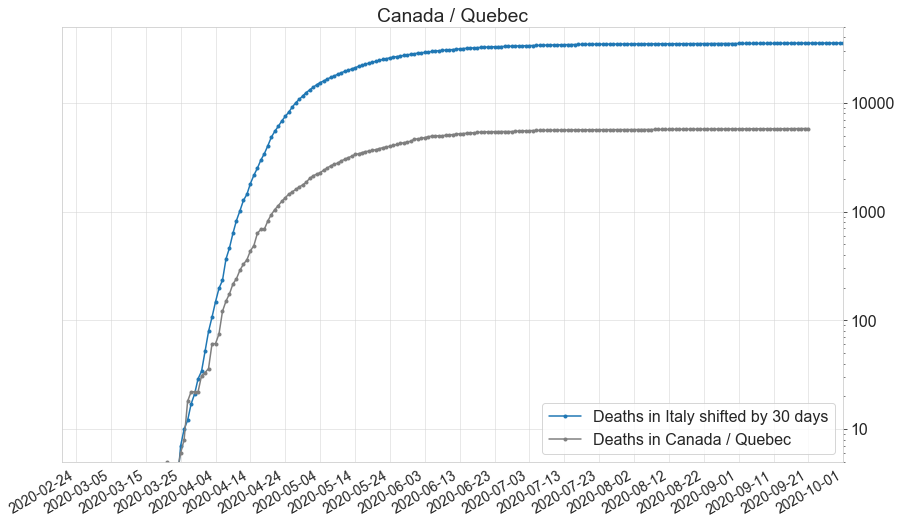

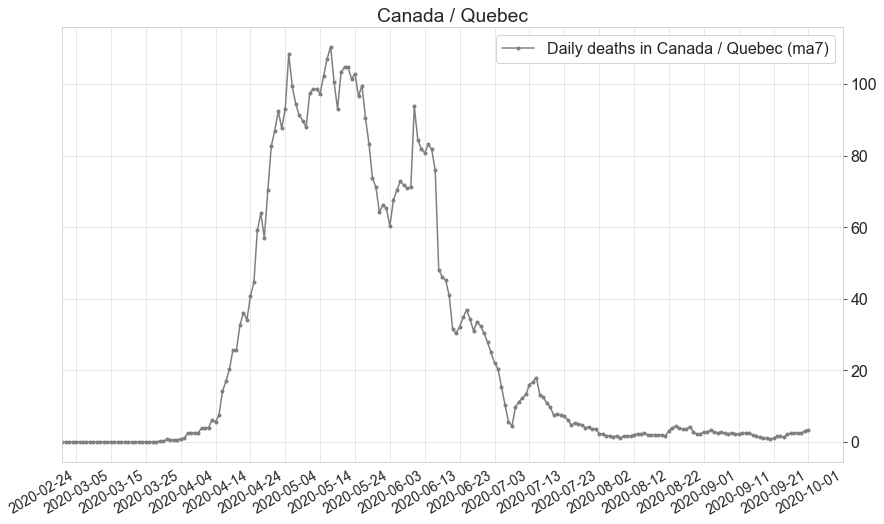

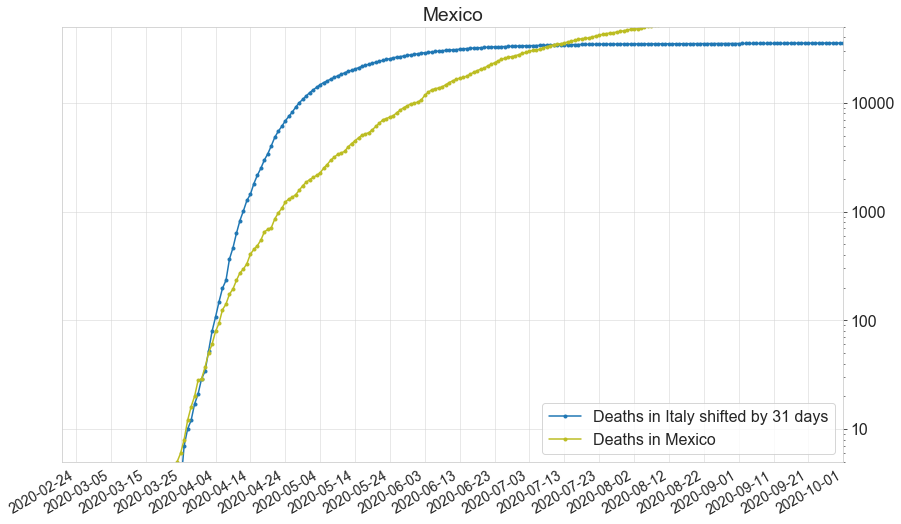

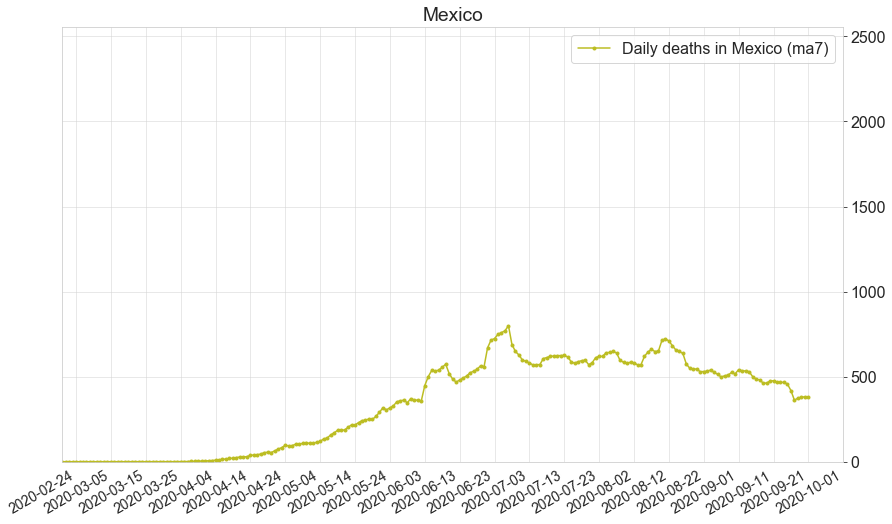

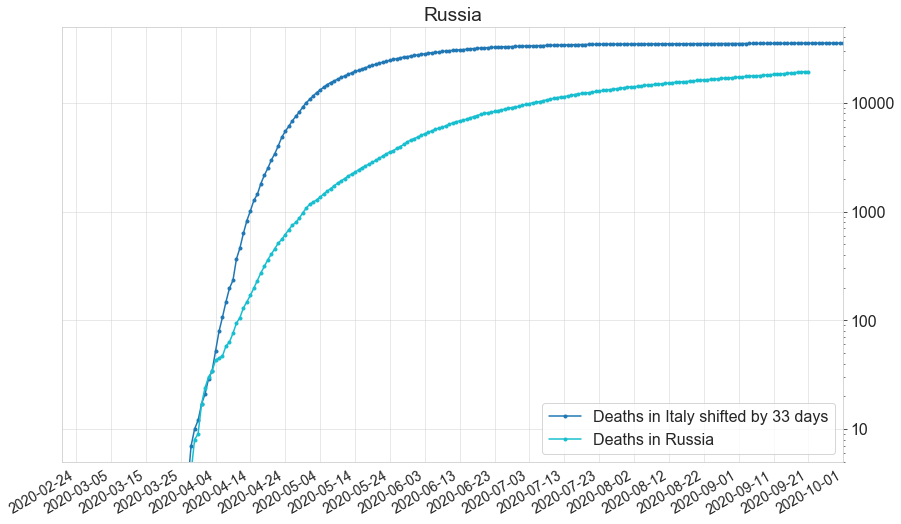

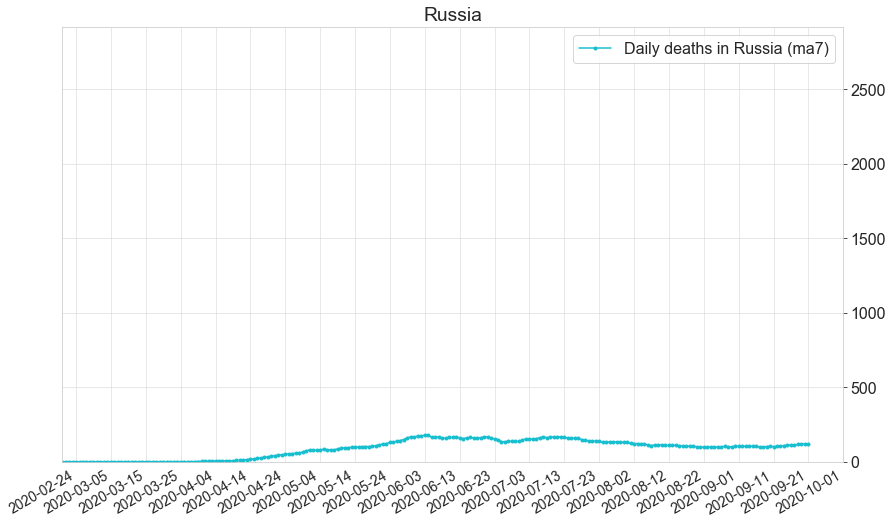

In [282]:
for (country, delay), color in list(zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[1:]))):
    _, ax = covid19.plot.subplots(subplot_kw={
        'yscale': 'log',
        'ylim': (5, 50000),
        # 'ylim': (0, country_data[country]['deaths'].max() * 1.1),
        'xlim': XLIM,
    }, figsize=(14, 8))
    covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths in Italy shifted by {delay} days', delay=delay, color=PALETTE_ONE[0])
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country}', color=color, date_interval=10)
    ax.set_title(f'{country}')
    ax.set(xlabel='', ylabel='')
    ax.legend()

    _, ax = covid19.plot.subplots(subplot_kw={
        # 'ylim': (1, 10000),
        # 'ylim': (0, country_data[country]['deaths'].max() * 1.1),
        'xlim': XLIM
    }, figsize=(14, 8))
    # covid19.plot.plot_data(ax, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True, min_periods=1).mean(), label=f'Daily deaths in Italy shifted by {delay} days', delay=delay, color=PALETTE_ONE[0])
    covid19.plot.plot_data(ax, world.sel(location=country)['daily_deaths7'], label=f'Daily deaths in {country} (ma7)', color=color, date_interval=10)
    ax.set_title(f'{country}')
    ax.set(xlabel='', ylabel='')
    ax.legend()
    try:
        ax.set(ylim=(0, world.sel(location=country).population.values / 50_000))
    except ValueError:
        pass